### Модули и базовые настройки

In [19]:
# Системные модули
import os
import sys
import re
import gc
import time
import datetime
import warnings

# Модули Math & Data
import pickle
import numpy as np
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

# Модули Machine Learning
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

# Настройки модулей
%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sys.version_info

sys.version_info(major=3, minor=7, micro=1, releaselevel='final', serial=0)

# 1. EDA & Feature Engineering

Приходиться делать сжатие данных почти на каждом этапе предварительной обработки данных, в противном случае данные не поместятся в пределах 12 Гб оперативной памяти.<br>
Влияет ли сжатие данных на конечную производительность, неизвестно.<br>

**Pipline данного раздела:**
1. Формирование датасета<br>
2. Проверка распределений предикторов<br>
3. Удаление выбросов<br>
4. Сжатие данных<br>
5. Создание датасета по месяцам, магазинам, товарам<br>
6. Создание Mean Encoded Features<br>
7. Создание Lag Features<br>
8. Преподготовка тестового датасета<br>
9. Завершающий этап преподготовки данных<br>

**Детализацию шагов можно найти в соответствующих разделах кода.**

### Класс DataProcessing реализует необходимые методы для EDA и Моделирования

In [20]:
class DataProcessing:  
    
    def __init__(self):
        pass
    
    @staticmethod
    def merge_items_charac(data_frame):
        """
        Объединяет предикторы item_id и item_charac_id в кортеж:
            :param data_frame: Таргетный датасет
            :return: None
        """
        merge_lst = []
        for item in zip(data_frame.item_id, data_frame.item_charac_id):
            merge_lst.append(item)
        data_frame['item_ids_char'] = merge_lst

    @staticmethod
    def to_numeric_features(data_frame, str = 'train'):
        """
        Меняет строковые значения предикторов на числовые:
            :param data_frame: Таргетный датасет
            :param str: Имя датасета
            :return: Кортеж измененых предикторов
        """
        item = []
        charac = []
        warehouse = []
        fabricator = []
        category = []

        for id_str in data_frame.item_id:
            item.append(int(id_str[2:]))
            
        if str == 'train':
            for id_str in data_frame.warehouse_id:
                warehouse.append(int(id_str[2:]))
        if str == 'items':
            for id_str in data_frame.fabricator_id:
                fabricator.append(int(id_str))
            for id_str in data_frame.item_category_id:
                category.append(int(id_str))
                
        for id_str in data_frame.item_charac_id:
            charac.append(int(id_str))

        return item, warehouse, fabricator, category, charac
    
    @staticmethod
    def box_plot(data_frame, f_name):
        """
        Сторит графики ("блоки с усами")
        распределений числовых предикторов.
            :param data_frame: Таргетный датасет
            :param f_name: Имя предиктора
            :return: None
        """
        plt.figure(figsize = (10, 4))
        plt.title('Распределение предиктора: ' + f_name)

        x_min = int(data_frame[f_name].min() - (abs(data_frame[f_name].min()) * 0.1))
        x_max = int(data_frame[f_name].max() + (abs(data_frame[f_name].max()) * 0.1))

        if x_min == 0:
            x_min = -1
        if x_max == 0:
            x_max = 1

        plt.xlim(x_min, x_max)
        sns.boxplot(x = data_frame[f_name])
    
    @staticmethod
    def add_date_block_num(data_frame):
        """
        Добавляет предикторы date_block_num и real_data
            :param data_frame: Таргетный датасет
            :return: None
        """
        lst_features = list()
        data_frame['real_date'] = pd.to_datetime(data_frame.date,
                                                 format='%d.%m.%Y %H:%M:%S')
        for item in data_frame.real_date:
            if item.year == 2018:
                lst_features.append(item.isocalendar()[1])
            if item.year == 2019:
                lst_features.append(item.isocalendar()[1] + 52)
            if item.year == 2020:
                lst_features.append(item.isocalendar()[1] + 104)

        data_frame['date_block_num'] = pd.Series(lst_features).astype('int')

    @staticmethod
    def compress_columns(data_frame, columns, keyword, search_type, datatype):
        """
        Сжимает столбцы указанные в columns
            :param data_frame: Таргетный датасет
            :param columns: Стобцы для сжатия
            :param keyword: Ключевое слово
            :param search_type: Тип поиска
            :param datatype: Тип данных после сжатия
            :return: Таргетный датасет после сжатия столбцов columns
        """
        if search_type == 'in':
            valid_features = [x for x in columns if keyword in x]
        elif search_type == 'start':
            valid_features = [x for x in columns if x.startswith(keyword)]
        if len(valid_features):
            for f in valid_features:
                data_frame[f] = data_frame[f].round().astype(datatype)
        return data_frame

    @staticmethod
    def data_compression(df):
        """
        Делает сжатие всех предикторов в датасете df
            :param df: Таргетный датасет
            :return: Таргетный датасет после сжатия
        """
        features = df.columns.values

        # Оригинальные предикторы
        if 'date_block_num' in features:
            df['date_block_num'] = df['date_block_num'].astype(np.int16)
        if 'warehouse_id' in features:
            df['warehouse_id'] = df['warehouse_id'].astype(np.int16)
        if 'item_price' in features:
            df['item_price'] = df['item_price'].astype(np.float32)
        if 'item_category_id' in features:
            df['item_category_id'] = df['item_category_id'].astype(np.int16)
        if 'item_id_avg_item_price' in features:
            df['item_id_avg_item_price'] = df['item_id_avg_item_price'].astype(np.float32)
            
        # Mean encoded предикторы & lag-ые предикторы
        df = hyper.compress_columns(df, features, 'item_ids_char_sum_item_cnt_day', 'in', np.int32)
        df = hyper.compress_columns(df, features, 'item_ids_char_avg_item_cnt_day','in', np.float32)

        df = hyper.compress_columns(df, features, 'warehouse_id_avg_item_price', 'in', np.float32)
        df = hyper.compress_columns(df, features, 'warehouse_id_sum_item_cnt_day', 'in', np.int32)
        df = hyper.compress_columns(df, features, 'warehouse_id_avg_item_cnt_day', 'in', np.float32)
        
        df = hyper.compress_columns(df, features, 'item_category_id_avg_item_price','in', np.float32)
        df = hyper.compress_columns(df, features, 'item_category_id_sum_item_cnt_day','in', np.int32)
        df = hyper.compress_columns(df, features, 'item_category_id_avg_item_cnt_day','in', np.float32)

        df = hyper.compress_columns(df, features, 'item_cnt_day', 'start', np.int16)

        return df
    
    @staticmethod
    def post_processing(model, model_name, train_x, val_x, test_x, train_y, val_y, test, metric):
        """
        Метод сохраняет данные и сериализует модель ML
            :param model: Модель ML пронозирующая уровень заказов
            :param model_name: Имя модели для сохранения
            :param train_x: Обучающий датасет (без таргета)
            :param val_x: Датасет валидации (без таргета)
            :param test_x: Тестовый датасет (без таргета)
            :param train_y: Ответы на обучающем наборе
            :param val_y: Ответы на валидации
            :param test: Тестовый датасет
            :param metric: функционал качества модели
            :return: Прогнозы на обучении, валидации, тесте
        """
        # Получим прогнозы
        train_pred = model.predict(train_x)
        val_pred = model.predict(val_x)
        test_pred = model.predict(test_x)

        # Выичлим среднеквадратичную ошибку на обучении и валидации
        if metric == 'rmse':
            train_rmse = mean_squared_error(train_y, train_pred, squared=False)
            print('Train RMSE: %f' % (train_rmse))
            val_rmse = mean_squared_error(val_y, val_pred, squared=False)
            print('Validation RMSE: %f' % (val_rmse))

        # Выичлим среднюю абсолютную ошибку на обучении и валидации
        if metric == 'mae':
            train_mae = mean_absolute_error(train_y, train_pred)
            print('Train MAE: %f' % (train_mae))
            val_mae = mean_absolute_error(val_y, val_pred)
            print('Validation MAE: %f' % (val_mae))

        # Сохраним вывод модели
        submission = pd.DataFrame({'ID': test.index, 'item_cnt_month': test_pred})
        submission.to_csv('%s_submission.csv' % model_name, index = False)

        # Сериализуем модель ML
        with open('%s_model.pickle' % model_name, 'wb') as file:
            pickle.dump(model, file)

        return train_pred, val_pred, test_pred
    
    @staticmethod
    def plot_feature_importances(importances, indices, features, title, dimensions):
        """
        Метод строит график feature importance для модели
            :param importances:
            :param indices:
            :param features:
            :param title: Название графика
            :param dimensions:
            :return: None
        """
        plt.figure(figsize = dimensions)
        plt.title(title)
        plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()   
        
    @staticmethod
    def add_num_month(data_frame):
        """
        Добавляет предиктор date_num_month - номер месяца
            :param data_frame: Таргетный датасет
            :return: Предиктор date_num_month
        """
        lst_month = []
        for item in data_frame.real_date:
            if item.year == 2018:
                lst_month.append(item.month - 1)
            elif item.year == 2019:
                lst_month.append(item.month + 11)
            else:
                lst_month.append(item.month + 23)

        data_frame['date_num_month'] = pd.Series(lst_month).astype('int')
    
hyper = DataProcessing()

### 1.1 Формирование датасета

In [21]:
# Директория с датасетами
print(os.listdir('../data'))

['delivery_time.csv', 'items.csv', 'old', 'test_orders.csv', 'train_orders.csv']


In [22]:
# Загружаем ежедневные исторические данные(train/test) + товрары
train = pd.read_csv('../data/train_orders.csv', sep = ',')
test  = pd.read_csv('../data/test_orders.csv', sep = ',')
items = pd.read_csv('../data/items.csv', sep = ',')
deliv = pd.read_csv('../data/delivery_time.csv', sep = ',')

# Дропним и неважные предикторы чтобы сэкономить место
train.drop(['item_name', 'item_charac_name', 'warehouse_name'], axis = 1, inplace = True)
items.drop(['item_name', 'item_charac_name'], axis = 1, inplace = True)

**1.1.1 "Причешим" датасет с информацией о товарах (items)**

In [23]:
# Посмотрим датасет с информацией 
# о товарах (items)
items.sample(10)

,item_id,item_charac_id,item_category_id,item_price,fabricator_id
234292,ДЗ000121181,44,nan,1328.00,000000022
247838,ДЗ000140378,77974,22.00,78972.00,000000165
176911,ДЗ000140378,178903,22.00,179901.00,000000165
546505,ДЗ000140378,67034,22.00,68032.00,165
207,ДЗ000107536,1,34.00,881.00,000000375
241041,ДЗ000140378,31503,22.00,32502.00,000000165
214590,ДЗ000173899,1,76.00,nan,000000571
501895,ДЗ000140378,216202,22.00,217200.00,000000165
573307,ДЗ000140378,285211,22.00,286208.00,165
296702,ДЗ000140378,177745,22.00,178743.00,000000165


In [24]:
# Информация о датасете: число
# предикторов, их типы ...
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636656 entries, 0 to 636655
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   item_id           636656 non-null  object 
 1   item_charac_id    636656 non-null  int64  
 2   item_category_id  597021 non-null  float64
 3   item_price        620390 non-null  float64
 4   fabricator_id     636656 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 24.3+ MB


In [29]:
# Заменим все пустые строки '' и <NULL> на np.nan
# чтобы pandas распознал их как пропущенные
items.replace(['', '<NULL>'], np.nan, inplace = True)

# Посмотрим на число пропущенных 
# значений в датасете items
items.isna().sum()

item_id             0
item_charac_id      0
item_category_id    0
item_price          0
fabricator_id       0
dtype: int64

In [30]:
# Заменим на 0 пропущенные 
# значения из датасета items 
items.fillna(0, inplace = True)
items.isna().sum()

item_id             0
item_charac_id      0
item_category_id    0
item_price          0
fabricator_id       0
dtype: int64

In [31]:
# Проверим изменения
items.sample(10)

,item_id,item_charac_id,item_category_id,item_price,fabricator_id
208787,ДЗ000160205,5,76.00,21327.00,000000070
262075,ДЗ000140378,27701,22.00,28700.00,000000165
400140,ДЗ000140378,131316,22.00,132314.00,000000165
588232,ДЗ000140378,291108,22.00,292105.00,165
614363,ДЗ000140378,58797,22.00,59795.00,165
599335,ДЗ000140378,408,22.00,1407.00,165
465977,ДЗ000140378,183593,22.00,184591.00,000000165
513311,ДЗ000140378,144022,22.00,145020.00,000000165
351522,ДЗ000028750,7,85.00,33321.00,000000099
380875,ДЗ000140378,97977,22.00,98975.00,000000165


In [32]:
# Описательные статистики
items.describe()

,item_charac_id,item_category_id,item_price
count,636656.00,636656.00,636656.00
mean,82323.65,42.58,89699.02
std,104820.76,37.41,163660.68
min,1.00,0.00,0.00
25%,4.00,22.00,7779.00
50%,5408.50,22.00,33831.00
75%,164573.25,76.00,165858.25
max,323738.00,244.00,102999790.00


**1.1.2 "Причешим" датасет с информацией о транзакциях (train)**

In [33]:
# Посмотрим датасет с информацией
# о транзакциях (train)
train.head(10)

,date,item_id,item_charac_id,warehouse_id,item_cnt_day
0,01.01.2018 0:00:00,ДЗ000054371,003,ДЗ0000007,1
1,01.01.2018 0:00:00,ДЗ000062737,001,ДЗ0000015,1
2,01.01.2018 0:00:00,ДЗ000014169,002,ДЗ0000015,1
3,01.01.2018 0:00:00,ДЗ000045133,023,ДЗ0000015,1
4,01.01.2018 0:00:00,ДЗ000038972,003,ДЗ0000015,1
5,01.01.2018 0:00:00,ДЗ000028264,001,ДЗ0000007,1
6,01.01.2018 0:00:00,ДЗ000032148,001,ДЗ0000015,1
7,01.01.2018 0:00:00,ДЗ000062149,001,ДЗ0000015,1
8,01.01.2018 0:00:00,ДЗ000053349,001,ДЗ0000015,1
9,01.01.2018 0:00:00,ДЗ000043359,001,ДЗ0000015,1


In [34]:
# Добавим предикторы (date_block_num, ral_date)
hyper.add_date_block_num(train)

# Добавим предиктор num_month
# hyper.add_num_month(train)

# Посмотрим обновленный датасет train
train.sample(10)

,date,item_id,item_charac_id,warehouse_id,item_cnt_day,real_date,date_block_num
1395901,17.09.2020 0:00:00,ДЗ000106062,003,ДЗ0000007,4,2020-09-17,142
15474,26.01.2018 0:00:00,ДЗ000059221,001,ДЗ0000015,1,2018-01-26,4
828192,21.12.2019 0:00:00,ДЗ000042770,016,ДЗ0000007,1,2019-12-21,103
697994,14.10.2019 0:00:00,ДЗ000006272,021,ДЗ0000015,4,2019-10-14,94
1398416,18.09.2020 0:00:00,ДЗ000180090,0000000006,ДЗ0000007,1,2020-09-18,142
1250801,24.07.2020 0:00:00,ДЗ000119041,001,ДЗ0000015,2,2020-07-24,134
227561,20.09.2018 0:00:00,ДЗ000044849,014,ДЗ0000015,3,2018-09-20,38
549185,12.07.2019 0:00:00,ДЗ000042751,023,ДЗ0000045,1,2019-07-12,80
883396,22.01.2020 0:00:00,ДЗ000077136,001,ДЗ0000045,1,2020-01-22,108
329588,21.12.2018 0:00:00,ДЗ000073926,001,ДЗ0000060,1,2018-12-21,51


In [35]:
# Информация о датасете: число
# предикторов, их типы ...
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404939 entries, 0 to 1404938
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1404939 non-null  object        
 1   item_id         1404939 non-null  object        
 2   item_charac_id  1404939 non-null  object        
 3   warehouse_id    1404939 non-null  object        
 4   item_cnt_day    1404939 non-null  int64         
 5   real_date       1404939 non-null  datetime64[ns]
 6   date_block_num  1404939 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 69.7+ MB


In [36]:
# Заменим все пустые строки '' и <NULL> на np.nan
# чтобы pandas распознал их как пропущенные
train.replace(['', '<NULL>'], np.nan, inplace = True)

# Посмотрим число пропущенных 
# значений в датасете
train.isna().sum()

date                0
item_id             0
item_charac_id    448
warehouse_id        0
item_cnt_day        0
real_date           0
date_block_num      0
dtype: int64

In [37]:
# Удалим наблюдения из датасета где
# встречаются пропущенные значения
train.dropna(inplace = True)
train.isna().sum()

date              0
item_id           0
item_charac_id    0
warehouse_id      0
item_cnt_day      0
real_date         0
date_block_num    0
dtype: int64

In [38]:
# Проверим изменения
train.sample(10)

,date,item_id,item_charac_id,warehouse_id,item_cnt_day,real_date,date_block_num
1350894,29.08.2020 0:00:00,ДЗ000121069,001,ДЗ0000123,2,2020-08-29,139
1093430,26.05.2020 0:00:00,ДЗ000110126,001,ДЗ0000060,1,2020-05-26,126
1069511,15.05.2020 0:00:00,ДЗ000083025,001,ДЗ0000007,1,2020-05-15,124
878959,20.01.2020 0:00:00,ДЗ000024709,004,ДЗ0000060,3,2020-01-20,108
455541,21.04.2019 0:00:00,ДЗ000105503,001,ДЗ0000007,1,2019-04-21,68
987633,21.03.2020 0:00:00,ДЗ000044848,022,ДЗ0000007,1,2020-03-21,116
1214239,09.07.2020 0:00:00,ДЗ000075051,007,ДЗ0000015,1,2020-07-09,132
534668,01.07.2019 0:00:00,ДЗ000044801,001,ДЗ0000007,3,2019-07-01,79
1078408,20.05.2020 0:00:00,ДЗ000104490,006,ДЗ0000015,1,2020-05-20,125
117367,08.06.2018 0:00:00,ДЗ000042778,012,ДЗ0000007,1,2018-06-08,23


**1.1.3 Объединим датасеты train и items $ \longrightarrow $ train**

In [39]:
# Преобразуем в числа значения предикторов 
# (item_id, warehouse_id) в датасете train
item, warehouse, _, _, charac = hyper.to_numeric_features(train)
train.drop(['item_id', 'warehouse_id', 'item_charac_id'], axis = 1, inplace = True)
train['item_id'] = item
train['warehouse_id'] = warehouse
train['item_charac_id'] = charac

# Преобразуем в числа значения предикторов 
# (item_id, warehouse_id) в датасете items
item, _, fabricator, category, _ = hyper.to_numeric_features(items, str = 'items')
items.drop(['item_id', 'fabricator_id'], axis = 1, inplace = True)
items['item_id'] = item
items['fabricator_id'] = fabricator
items['item_category_id'] = category
train.dtypes

date                      object
item_cnt_day               int64
real_date         datetime64[ns]
date_block_num             int32
item_id                    int64
warehouse_id               int64
item_charac_id             int64
dtype: object

In [40]:
# Типы предикторов items
items.dtypes

item_charac_id        int64
item_category_id      int64
item_price          float64
item_id               int64
fabricator_id         int64
dtype: object

In [41]:
# Описательные статистики
# датасета train
train.describe()

,item_cnt_day,date_block_num,item_id,warehouse_id,item_charac_id
count,1404491.00,1404491.00,1404491.00,1404491.00,1404491.00
mean,3.80,86.70,66936.78,24.16,5.43
std,2531.43,39.86,35937.22,24.04,9.52
min,-1.00,1.00,6166.00,7.00,1.00
25%,1.00,54.00,43694.00,7.00,1.00
50%,1.00,94.00,58350.00,15.00,2.00
75%,2.00,123.00,90850.50,45.00,5.00
max,3000000.00,142.00,184132.00,157.00,171.00


In [44]:
# Сжатие предикторов item_id и item_charac_id
# перед объединением их в кортеж
train['item_charac_id'].astype(np.int8)
train['item_id'].astype(np.int32)
items['item_charac_id'].astype(np.int32)
items['item_id'].astype(np.int32)
train

,date,item_cnt_day,real_date,date_block_num,item_id,warehouse_id,item_charac_id
0,01.01.2018 0:00:00,1,2018-01-01,1,54371,7,3
1,01.01.2018 0:00:00,1,2018-01-01,1,62737,15,1
2,01.01.2018 0:00:00,1,2018-01-01,1,14169,15,2
3,01.01.2018 0:00:00,1,2018-01-01,1,45133,15,23
4,01.01.2018 0:00:00,1,2018-01-01,1,38972,15,3
...,...,...,...,...,...,...,...
1404934,20.09.2020 0:00:00,1,2020-09-20,142,59280,7,13
1404935,20.09.2020 0:00:00,1,2020-09-20,142,61381,7,4
1404936,20.09.2020 0:00:00,1,2020-09-20,142,67699,7,1
1404937,20.09.2020 0:00:00,1,2020-09-20,142,71852,7,1


In [45]:
# Посмотрим изменения items
items

,item_charac_id,item_category_id,item_price,item_id,fabricator_id
0,1,27,4790.00,71668,263
1,1,27,8232.00,172447,507
2,1,27,9209.00,172449,507
3,1,27,6300.00,147711,507
4,1,27,1880.00,147702,507
...,...,...,...,...,...
636651,3,85,2335.00,182630,861
636652,1,85,2335.00,182630,861
636653,2,85,2335.00,182630,861
636654,1,76,460.00,95112,336


In [46]:
# Объединим (в кортеж) предикторы (item_id, 
# item_charac_id) в items и посмотрим результат
hyper.merge_items_charac(items)

# Дропним уже ненужные предикторы
items.drop(['item_id', 'item_charac_id'], axis = 1, inplace = True)
items

,item_category_id,item_price,fabricator_id,item_ids_char
0,27,4790.00,263,"(71668, 1)"
1,27,8232.00,507,"(172447, 1)"
2,27,9209.00,507,"(172449, 1)"
3,27,6300.00,507,"(147711, 1)"
4,27,1880.00,507,"(147702, 1)"
...,...,...,...,...
636651,85,2335.00,861,"(182630, 3)"
636652,85,2335.00,861,"(182630, 1)"
636653,85,2335.00,861,"(182630, 2)"
636654,76,460.00,336,"(95112, 1)"


In [47]:
# Объединим (в кортеж) предикторы (item_id, 
# item_charac_id) в train и посмотрим результат
hyper.merge_items_charac(train)

# Дропним уже ненужные предикторы
train.drop(['item_id', 'item_charac_id', 'real_date'], axis = 1, inplace = True)
train

,date,item_cnt_day,date_block_num,warehouse_id,item_ids_char
0,01.01.2018 0:00:00,1,1,7,"(54371, 3)"
1,01.01.2018 0:00:00,1,1,15,"(62737, 1)"
2,01.01.2018 0:00:00,1,1,15,"(14169, 2)"
3,01.01.2018 0:00:00,1,1,15,"(45133, 23)"
4,01.01.2018 0:00:00,1,1,15,"(38972, 3)"
...,...,...,...,...,...
1404934,20.09.2020 0:00:00,1,142,7,"(59280, 13)"
1404935,20.09.2020 0:00:00,1,142,7,"(61381, 4)"
1404936,20.09.2020 0:00:00,1,142,7,"(67699, 1)"
1404937,20.09.2020 0:00:00,1,142,7,"(71852, 1)"


In [48]:
# К train добавим предиктор item_price из items
train = pd.merge(train, items, how = 'left', on = 'item_ids_char')

In [49]:
train

,date,item_cnt_day,date_block_num,warehouse_id,item_ids_char,item_category_id,item_price,fabricator_id
0,01.01.2018 0:00:00,1,1,7,"(54371, 3)",66.00,10934.00,85.00
1,01.01.2018 0:00:00,1,1,15,"(62737, 1)",85.00,6825.00,235.00
2,01.01.2018 0:00:00,1,1,15,"(14169, 2)",85.00,21390.00,22.00
3,01.01.2018 0:00:00,1,1,15,"(45133, 23)",76.00,10047.00,164.00
4,01.01.2018 0:00:00,1,1,15,"(38972, 3)",22.00,6390.00,22.00
...,...,...,...,...,...,...,...,...
1404488,20.09.2020 0:00:00,1,142,7,"(59280, 13)",85.00,5788.00,227.00
1404489,20.09.2020 0:00:00,1,142,7,"(61381, 4)",66.00,1090.00,22.00
1404490,20.09.2020 0:00:00,1,142,7,"(67699, 1)",14.00,17372.00,251.00
1404491,20.09.2020 0:00:00,1,142,7,"(71852, 1)",22.00,4445.00,258.00


In [50]:
# Проверим датасет train на nan-значения после
# мержа. Заменяя все '' и <NULL> на np.nan
train.replace(['', '<NULL>'], np.nan, inplace = True)
train.isna().sum()

date                   0
item_cnt_day           0
date_block_num         0
warehouse_id           0
item_ids_char          0
item_category_id    1675
item_price          1675
fabricator_id       1675
dtype: int64

In [51]:
# Заменим на 0 nan-значения 
# в предикторе item_price
train.fillna(0, inplace = True)
train.isna().sum()

date                0
item_cnt_day        0
date_block_num      0
warehouse_id        0
item_ids_char       0
item_category_id    0
item_price          0
fabricator_id       0
dtype: int64

In [52]:
# Проверим изменеия типов предикторов
train.dtypes

date                 object
item_cnt_day          int64
date_block_num        int32
warehouse_id          int64
item_ids_char        object
item_category_id    float64
item_price          float64
fabricator_id       float64
dtype: object

In [53]:
# Посмотрим на итоговый датасет
train

,date,item_cnt_day,date_block_num,warehouse_id,item_ids_char,item_category_id,item_price,fabricator_id
0,01.01.2018 0:00:00,1,1,7,"(54371, 3)",66.00,10934.00,85.00
1,01.01.2018 0:00:00,1,1,15,"(62737, 1)",85.00,6825.00,235.00
2,01.01.2018 0:00:00,1,1,15,"(14169, 2)",85.00,21390.00,22.00
3,01.01.2018 0:00:00,1,1,15,"(45133, 23)",76.00,10047.00,164.00
4,01.01.2018 0:00:00,1,1,15,"(38972, 3)",22.00,6390.00,22.00
...,...,...,...,...,...,...,...,...
1404488,20.09.2020 0:00:00,1,142,7,"(59280, 13)",85.00,5788.00,227.00
1404489,20.09.2020 0:00:00,1,142,7,"(61381, 4)",66.00,1090.00,22.00
1404490,20.09.2020 0:00:00,1,142,7,"(67699, 1)",14.00,17372.00,251.00
1404491,20.09.2020 0:00:00,1,142,7,"(71852, 1)",22.00,4445.00,258.00


### 1.2 Проверка распределений предикторов

**Графики (ящик с усами) распределений предикторов**

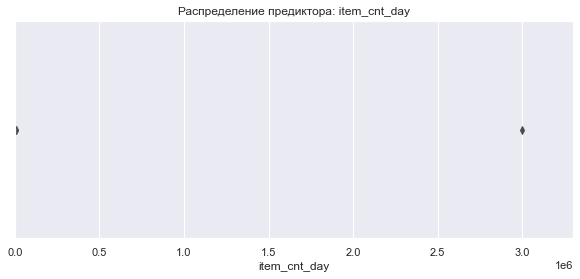

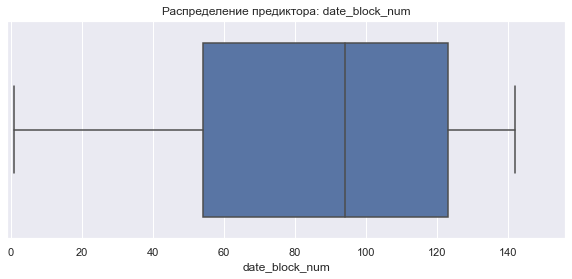

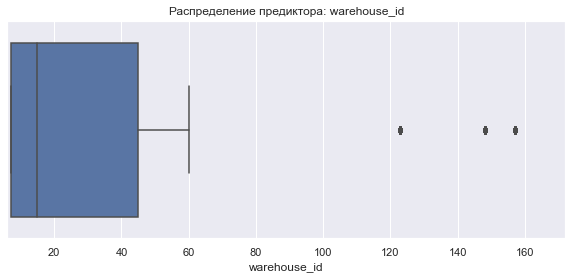

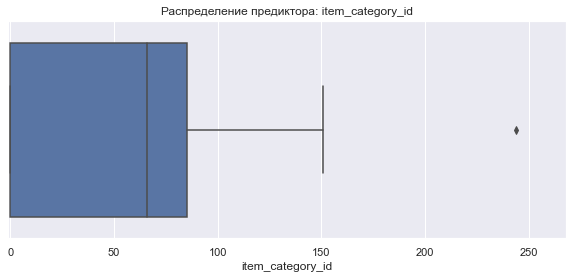

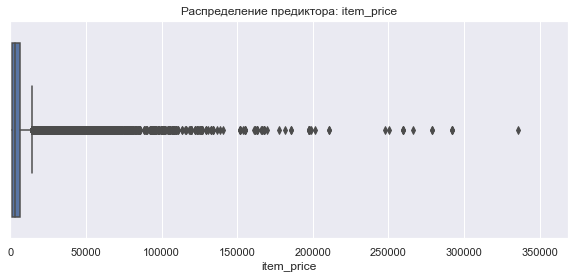

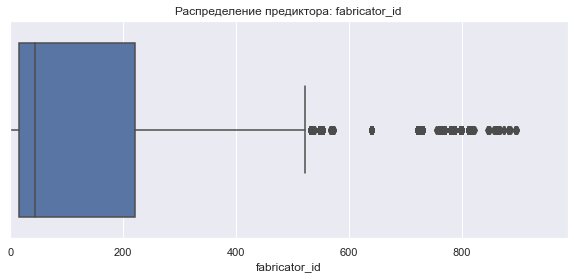

In [54]:
# Построим ящики с усами для числовых предикторов
plot_features = [x for x in train.columns.values if train[x].dtype != 'object']
for f in plot_features:
    hyper.box_plot(train, f)

    Как видно из ящиков с усами, в "item_price" и "item_cnt_day" есть экстримальные выбросы. 

In [55]:
# Посмотрим описательные статистики
train.describe()

,item_cnt_day,date_block_num,warehouse_id,item_category_id,item_price,fabricator_id
count,1404493.00,1404493.00,1404493.00,1404493.00,1404493.00,1404493.00
mean,3.80,86.70,24.16,49.68,5189.67,119.37
std,2531.43,39.86,24.04,40.42,6583.28,136.15
min,-1.00,1.00,7.00,0.00,0.00,0.00
25%,1.00,54.00,7.00,0.00,1290.00,16.00
50%,1.00,94.00,15.00,66.00,2958.00,43.00
75%,2.00,123.00,45.00,85.00,6590.00,221.00
max,3000000.00,142.00,157.00,244.00,335300.00,898.00


Как можно заметить, для предиктора $item\_price$ средннее значение $ \overline x = 5189.67,$ когда как стандарное отклонение $\sigma = 6583.28$ и $ \max = 335300.00.$ Аналогичная ситуация и для предиктора $item\_cnt\_day$ средннее значение $ \overline x = 3.80,$  стандарное отклонение $\sigma = 2531.43$ и $ \max = 3000000.00.$ Для исправление данной ситуации удалим выбросы в данных предикторах.

### 1.3 Удаление выбросов

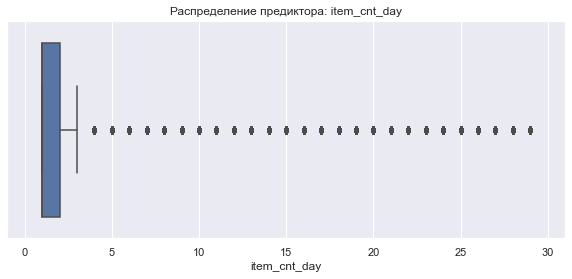

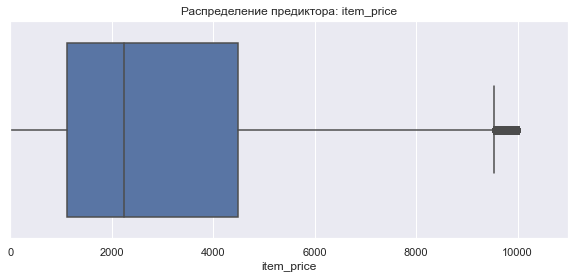

In [56]:
# Избавление от выбросов и отрицательных значений
train = train[(train['item_cnt_day'] < 30) & (train['item_cnt_day'] >= 0)]
train = train[(train['item_price'] < 10000) & (train['item_price'] >= 0)]

# Построим распределения предикторов item_price
# и item_cnt_day после удаления выбросов
plot_features = ['item_cnt_day', 'item_price']
for f in plot_features:
    hyper.box_plot(train, f)

In [57]:
# Описательные статистики 
# после удаления выбросов
train.describe()

,item_cnt_day,date_block_num,warehouse_id,item_category_id,item_price,fabricator_id
count,1195920.00,1195920.00,1195920.00,1195920.00,1195920.00,1195920.00
mean,1.65,86.75,24.14,48.75,3083.67,112.91
std,1.54,39.78,24.01,41.27,2448.08,134.06
min,1.00,1.00,7.00,0.00,0.00,0.00
25%,1.00,55.00,7.00,0.00,1125.00,16.00
50%,1.00,94.00,15.00,66.00,2249.00,23.00
75%,2.00,123.00,45.00,85.00,4490.00,213.00
max,29.00,142.00,157.00,244.00,9999.00,898.00








Теперь гуд!

In [58]:
train

,date,item_cnt_day,date_block_num,warehouse_id,item_ids_char,item_category_id,item_price,fabricator_id
1,01.01.2018 0:00:00,1,1,15,"(62737, 1)",85.00,6825.00,235.00
4,01.01.2018 0:00:00,1,1,15,"(38972, 3)",22.00,6390.00,22.00
5,01.01.2018 0:00:00,1,1,7,"(28264, 1)",1.00,1590.00,94.00
8,01.01.2018 0:00:00,1,1,15,"(53349, 1)",76.00,3200.00,0.00
9,01.01.2018 0:00:00,1,1,15,"(43359, 1)",85.00,3567.00,160.00
...,...,...,...,...,...,...,...,...
1404486,20.09.2020 0:00:00,1,142,15,"(58351, 1)",0.00,3110.00,22.00
1404487,20.09.2020 0:00:00,1,142,15,"(58371, 1)",76.00,3374.00,22.00
1404488,20.09.2020 0:00:00,1,142,7,"(59280, 13)",85.00,5788.00,227.00
1404489,20.09.2020 0:00:00,1,142,7,"(61381, 4)",66.00,1090.00,22.00


### 1.4 Сжатие данных

In [59]:
# Получим диапазоны каждого объекта, чтобы 
# выбрать наиболее подходящий размер данных
print ('-------------------------------------------------------')
print ('train:')
for f in train.columns.values:
    print ('%s: %s ~ %s' %(f, train[f].min(), train[f].max()))

-------------------------------------------------------
train:
date: 01.01.2018 0:00:00 ~ 31.12.2019 0:00:00
item_cnt_day: 1 ~ 29
date_block_num: 1 ~ 142
warehouse_id: 7 ~ 157
item_ids_char: (6178, 3) ~ (184132, 1)
item_category_id: 0.0 ~ 244.0
item_price: 0.0 ~ 9999.0
fabricator_id: 0.0 ~ 898.0


In [60]:
# Посмотрим объем используемой 
# памяти до сжатия
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195920 entries, 1 to 1404491
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date              1195920 non-null  object 
 1   item_cnt_day      1195920 non-null  int64  
 2   date_block_num    1195920 non-null  int32  
 3   warehouse_id      1195920 non-null  int64  
 4   item_ids_char     1195920 non-null  object 
 5   item_category_id  1195920 non-null  float64
 6   item_price        1195920 non-null  float64
 7   fabricator_id     1195920 non-null  float64
dtypes: float64(3), int32(1), int64(2), object(2)
memory usage: 77.6+ MB


In [61]:
# Сжатие предикторов 
# в соответствии с диапазоном
train = hyper.data_compression(train)
items = hyper.data_compression(items)

In [62]:
# Посмотрим объем используемой 
# памяти после сжатия
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195920 entries, 1 to 1404491
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date              1195920 non-null  object 
 1   item_cnt_day      1195920 non-null  int16  
 2   date_block_num    1195920 non-null  int16  
 3   warehouse_id      1195920 non-null  int16  
 4   item_ids_char     1195920 non-null  object 
 5   item_category_id  1195920 non-null  int16  
 6   item_price        1195920 non-null  float32
 7   fabricator_id     1195920 non-null  float64
dtypes: float32(1), float64(1), int16(4), object(2)
memory usage: 50.2+ MB


In [63]:
# Посмотрим на преобразованный датасет
train

,date,item_cnt_day,date_block_num,warehouse_id,item_ids_char,item_category_id,item_price,fabricator_id
1,01.01.2018 0:00:00,1,1,15,"(62737, 1)",85,6825.00,235.00
4,01.01.2018 0:00:00,1,1,15,"(38972, 3)",22,6390.00,22.00
5,01.01.2018 0:00:00,1,1,7,"(28264, 1)",1,1590.00,94.00
8,01.01.2018 0:00:00,1,1,15,"(53349, 1)",76,3200.00,0.00
9,01.01.2018 0:00:00,1,1,15,"(43359, 1)",85,3567.00,160.00
...,...,...,...,...,...,...,...,...
1404486,20.09.2020 0:00:00,1,142,15,"(58351, 1)",0,3110.00,22.00
1404487,20.09.2020 0:00:00,1,142,15,"(58371, 1)",76,3374.00,22.00
1404488,20.09.2020 0:00:00,1,142,7,"(59280, 13)",85,5788.00,227.00
1404489,20.09.2020 0:00:00,1,142,7,"(61381, 4)",66,1090.00,22.00


### 1.5 Создание датасета по месяцам, складам, товарам

    В случае если в течение нескольких месяцев в некоторых магазинах не было записи о продаже какого-то товара, она должна быть записана как 0.

In [64]:
# Создадим таблицу со с следующими предикторами
index_cols = ['warehouse_id', 'item_ids_char', 'date_block_num']

# Для каждого месяца мы создаем 
# таблицу всевозможных пар склад/товар
grid = []

for block_num in train['date_block_num'].unique():
    cur_warehouses = train.loc[train['date_block_num'] == block_num, 'warehouse_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_ids_char'].unique()
    grid.append(np.array(list(product(*[cur_warehouses, cur_items, [block_num]])), dtype = 'object'))
    
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = object)
grid = hyper.data_compression(grid)

In [65]:
# Посмотрим информацию по 
# датасету grid
grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855035 entries, 0 to 2855034
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   warehouse_id    int16 
 1   item_ids_char   object
 2   date_block_num  int16 
dtypes: int16(2), object(1)
memory usage: 32.7+ MB


In [66]:
# Посмотрим датасет grid
grid

,warehouse_id,item_ids_char,date_block_num
0,15,"(62737, 1)",1
1,15,"(38972, 3)",1
2,15,"(28264, 1)",1
3,15,"(53349, 1)",1
4,15,"(43359, 1)",1
...,...,...,...
2855030,148,"(144698, 1)",142
2855031,148,"(24573, 2)",142
2855032,148,"(175247, 1)",142
2855033,148,"(59280, 13)",142


### 1.6 Создание Mean Encodings

На данном шаге добавим следующие 6 предикторов:<br>
<br>
‘item_id_avg_item_price’: Среднемесячная цена товара в месяц item_id<br>
‘item_id_sum_item_cnt_day’: Ежемесячное общее количество товаров на item_id<br>
‘item_id_avg_item_cnt_day’: Среднемесячное количество товаров на item_id<br>
‘warehouse_id_avg_item_price’: Среднемесячная цена товара на складе<br>
‘warehouse_id_sum_item_cnt_day’: Ежемесячное общее количество товаров на складе<br>
‘warehouse_id_avg_item_cnt_day’: Среднемесячное количество товаров на складе<br>

In [67]:
# Сделаем датасет аналогичный items только без цены
items_tmp = items.drop('item_price', axis = 1)

# Группировка товаров по неделям, по складу, по товару, сумма продаж товара, средняя цена
train_m = train.groupby(['date_block_num', 'warehouse_id', 'item_ids_char']).\
                    agg({'item_cnt_day': 'sum', 'item_price': np.mean}).reset_index()
train_m = pd.merge(grid, train_m, on = ['date_block_num', 'warehouse_id', 'item_ids_char'], how = 'left').fillna(0)
train_m = pd.merge(train_m, items_tmp, on = 'item_ids_char', how = 'left')

In [68]:
# Заменим на 0 nan-значения в датасете train_m 
train_m.replace(['', '<NULL>'], np.nan, inplace = True)
train_m.fillna(0, inplace = True)

# Сделаем сжатие датасета
train_m = hyper.data_compression(train_m)

# Посмторим на результат
train_m

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id
0,15,"(62737, 1)",1,2,6825.00,85,235.00
1,15,"(38972, 3)",1,2,6390.00,22,22.00
2,15,"(28264, 1)",1,0,0.00,1,94.00
3,15,"(53349, 1)",1,2,3200.00,76,0.00
4,15,"(43359, 1)",1,5,3567.00,85,160.00
...,...,...,...,...,...,...,...
2855037,148,"(144698, 1)",142,0,0.00,76,224.00
2855038,148,"(24573, 2)",142,0,0.00,76,73.00
2855039,148,"(175247, 1)",142,0,0.00,57,76.00
2855040,148,"(59280, 13)",142,0,0.00,85,227.00


**1.6.1 Причешим датасет по срокам доставки**

In [69]:
# Посмотрим на датасет
deliv

,delivery,fabricator_id,warehouse_id
0,30.00,2.00,ДЗ0000007
1,18.00,2.00,ДЗ0000015
2,31.00,2.00,ДЗ0000045
3,33.00,2.00,ДЗ0000060
4,28.50,2.00,ДЗ0000123
...,...,...,...
1397,22.00,859.00,ДЗ0000123
1398,13.00,861.00,ДЗ0000007
1399,41.00,861.00,ДЗ0000015
1400,26.00,861.00,ДЗ0000060


In [70]:
# Сделаем код склада числом
wareh = []
for id_str in deliv.warehouse_id:
    wareh.append(int(id_str[2:]))
    
deliv['warehouse_id'] = wareh
deliv

,delivery,fabricator_id,warehouse_id
0,30.00,2.00,7
1,18.00,2.00,15
2,31.00,2.00,45
3,33.00,2.00,60
4,28.50,2.00,123
...,...,...,...
1397,22.00,859.00,123
1398,13.00,861.00,7
1399,41.00,861.00,15
1400,26.00,861.00,60


In [71]:
# Добавим к комбинации товар-склад предиктор срок доставки
train_m = pd.merge(train_m, deliv, on = ['warehouse_id', 'fabricator_id'], how = 'left').fillna(np.mean(deliv.delivery))
train_m

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id,delivery
0,15,"(62737, 1)",1,2,6825.00,85,235.00,35.89
1,15,"(38972, 3)",1,2,6390.00,22,22.00,27.00
2,15,"(28264, 1)",1,0,0.00,1,94.00,24.25
3,15,"(53349, 1)",1,2,3200.00,76,0.00,35.89
4,15,"(43359, 1)",1,5,3567.00,85,160.00,49.00
...,...,...,...,...,...,...,...,...
2855037,148,"(144698, 1)",142,0,0.00,76,224.00,35.89
2855038,148,"(24573, 2)",142,0,0.00,76,73.00,35.89
2855039,148,"(175247, 1)",142,0,0.00,57,76.00,35.89
2855040,148,"(59280, 13)",142,0,0.00,85,227.00,35.89


**1.6.2 Создание mean encoded предикторов**

In [74]:
# Создание mean encoded предикторов
for type_id in ['item_ids_char', 'warehouse_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',   np.mean,'avg'), 
                                           ('item_cnt_day', np.sum, 'sum'), 
                                           ('item_cnt_day', np.mean,'avg')]:   
        mean_df = train.groupby([type_id, 'date_block_num']).aggregate(aggregator).\
                                reset_index()[[column_id, type_id, 'date_block_num']]
        mean_df.columns = [type_id + '_' + aggtype + '_' + column_id, type_id, 'date_block_num']
        train_m = pd.merge(train_m, mean_df, on = ['date_block_num', type_id], how = 'left')
        
        del mean_df
        gc.collect()

In [75]:
# Попросим GC почистить память
del train
gc.collect()

# Посмторим на результат
# добавления mean encoded
train_m

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price,item_ids_char_sum_item_cnt_day,item_ids_char_avg_item_cnt_day,warehouse_id_avg_item_price,warehouse_id_sum_item_cnt_day,warehouse_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,15,"(62737, 1)",1,2,6825.00,85,235.00,35.89,6825.00,2,1.00,3167.99,2546.00,1.65,4282.81,542.00,1.67
1,15,"(38972, 3)",1,2,6390.00,22,22.00,27.00,6390.00,2,1.00,3167.99,2546.00,1.65,5946.90,231.00,1.38
2,15,"(28264, 1)",1,0,0.00,1,94.00,24.25,1590.00,2,1.00,3167.99,2546.00,1.65,2424.67,14.00,1.56
3,15,"(53349, 1)",1,2,3200.00,76,0.00,35.89,3200.00,2,1.00,3167.99,2546.00,1.65,2452.94,908.00,2.13
4,15,"(43359, 1)",1,5,3567.00,85,160.00,49.00,3567.00,11,1.22,3167.99,2546.00,1.65,4282.81,542.00,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855037,148,"(144698, 1)",142,0,0.00,76,224.00,35.89,5141.00,1,1.00,4588.55,13.00,1.18,2330.18,5380.00,2.00
2855038,148,"(24573, 2)",142,0,0.00,76,73.00,35.89,788.00,4,4.00,4588.55,13.00,1.18,2330.18,5380.00,2.00
2855039,148,"(175247, 1)",142,0,0.00,57,76.00,35.89,6028.00,1,1.00,4588.55,13.00,1.18,3772.61,1652.00,1.48
2855040,148,"(59280, 13)",142,0,0.00,85,227.00,35.89,5788.00,1,1.00,4588.55,13.00,1.18,4570.26,2424.00,1.44


In [76]:
# Заполнение пропущенных значений
# (если имеются)
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())
    elif 'item_category_id' in f:
        train_m[f] = train_m[f].fillna(0)

# Сжатие данных
train_m = hyper.data_compression(train_m)
train_m.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2855042 entries, 0 to 2855041
Columns: 17 entries, warehouse_id to item_category_id_avg_item_cnt_day
dtypes: float32(7), float64(2), int16(4), int32(3), object(1)
memory usage: 217.8+ MB


In [77]:
train_m

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price,item_ids_char_sum_item_cnt_day,item_ids_char_avg_item_cnt_day,warehouse_id_avg_item_price,warehouse_id_sum_item_cnt_day,warehouse_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,15,"(62737, 1)",1,2,6825.00,85,235.00,35.89,6825.00,2,1.00,3168.00,2546,2.00,4283.00,542,2.00
1,15,"(38972, 3)",1,2,6390.00,22,22.00,27.00,6390.00,2,1.00,3168.00,2546,2.00,5947.00,231,1.00
2,15,"(28264, 1)",1,0,0.00,1,94.00,24.25,1590.00,2,1.00,3168.00,2546,2.00,2425.00,14,2.00
3,15,"(53349, 1)",1,2,3200.00,76,0.00,35.89,3200.00,2,1.00,3168.00,2546,2.00,2453.00,908,2.00
4,15,"(43359, 1)",1,5,3567.00,85,160.00,49.00,3567.00,11,1.00,3168.00,2546,2.00,4283.00,542,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855037,148,"(144698, 1)",142,0,0.00,76,224.00,35.89,5141.00,1,1.00,4589.00,13,1.00,2330.00,5380,2.00
2855038,148,"(24573, 2)",142,0,0.00,76,73.00,35.89,788.00,4,4.00,4589.00,13,1.00,2330.00,5380,2.00
2855039,148,"(175247, 1)",142,0,0.00,57,76.00,35.89,6028.00,1,1.00,4589.00,13,1.00,3773.00,1652,1.00
2855040,148,"(59280, 13)",142,0,0.00,85,227.00,35.89,5788.00,1,1.00,4589.00,13,1.00,4570.00,2424,1.00


### 1.7 Создание Lag Features

Мы создали Mean Encodings предикторы, но мы не можем использовать их во время предсказания (потому что мы не знаем целевую переменную, поэтому и не можем их кодировать). Поэтому создадим lagи для всех этих Mean Encodings предикторов кодирования и будем использовать это запаздывающее значение (среднее кодирование при $t-1, t-2 ..$) чтобы предсказать нашу целевую переменную.<br>
<br>
На данном шаге добавим lag features с различными периодами lag-ов:<br>
<br>
‘item_ids_char_avg_item_price’,<br>
‘item_ids_char_sum_item_cnt_day’<br>
‘item_ids_char_avg_item_cnt_day’<br>
‘warehouse_id_avg_item_price’<br>
‘warehouse_id_sum_item_cnt_day’<br>
‘warehouse_id_avg_item_cnt_day’<br>
‘item_cnt_day’

In [78]:
# Проверка положения базы для lag features
train_m.columns.values[8:]

array(['item_ids_char_avg_item_price', 'item_ids_char_sum_item_cnt_day',
       'item_ids_char_avg_item_cnt_day', 'warehouse_id_avg_item_price',
       'warehouse_id_sum_item_cnt_day', 'warehouse_id_avg_item_cnt_day',
       'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day'], dtype=object)

In [259]:
# Получим все еженедельные features, 
# Mean Encoded fatures все основаны на неделях
lag_features = list(train_m.columns[8:]) + ['item_cnt_day']

# Выбранные недели от текущего месяца
lags = [1, 2, 3, 4, 6]

In [260]:
# Создание lag-ых предикторов
for lag in lags:
    train_new_df = train_m.copy()
    
    # Сделаем смещение на нужный lag
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num', 'warehouse_id', 'item_ids_char'] + lag_features]
    
    # Назовем предикторы как lag features недели
    train_new_df.columns = ['date_block_num', 'warehouse_id', 'item_ids_char'] + [x + '_lag_' + str(lag) for x in lag_features]
    train_m = pd.merge(train_m, train_new_df, on = ['date_block_num', 'warehouse_id', 'item_ids_char'], how = 'left')
    
    del train_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 4 processed
lag 6 processed


In [261]:
# Заполнение пропущенных значений
# (если имеются)
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

train_m = hyper.data_compression(train_m)
train_m.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2855042 entries, 0 to 2855041
Columns: 67 entries, warehouse_id to item_cnt_day_lag_6
dtypes: float32(37), float64(2), int16(9), int32(18), object(1)
memory usage: 735.2+ MB


In [262]:
# Посмотрим результат добавления 
# lag-ых предикторов
train_m.head(10)

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price,item_ids_char_sum_item_cnt_day,item_ids_char_avg_item_cnt_day,warehouse_id_avg_item_price,warehouse_id_sum_item_cnt_day,warehouse_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day,item_ids_char_avg_item_price_lag_1,item_ids_char_sum_item_cnt_day_lag_1,item_ids_char_avg_item_cnt_day_lag_1,warehouse_id_avg_item_price_lag_1,warehouse_id_sum_item_cnt_day_lag_1,warehouse_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_ids_char_avg_item_price_lag_2,item_ids_char_sum_item_cnt_day_lag_2,item_ids_char_avg_item_cnt_day_lag_2,warehouse_id_avg_item_price_lag_2,warehouse_id_sum_item_cnt_day_lag_2,warehouse_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_ids_char_avg_item_price_lag_3,item_ids_char_sum_item_cnt_day_lag_3,item_ids_char_avg_item_cnt_day_lag_3,warehouse_id_avg_item_price_lag_3,warehouse_id_sum_item_cnt_day_lag_3,warehouse_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_ids_char_avg_item_price_lag_4,item_ids_char_sum_item_cnt_day_lag_4,item_ids_char_avg_item_cnt_day_lag_4,warehouse_id_avg_item_price_lag_4,warehouse_id_sum_item_cnt_day_lag_4,warehouse_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_ids_char_avg_item_price_lag_6,item_ids_char_sum_item_cnt_day_lag_6,item_ids_char_avg_item_cnt_day_lag_6,warehouse_id_avg_item_price_lag_6,warehouse_id_sum_item_cnt_day_lag_6,warehouse_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
0,15,"(62737, 1)",1,2,6825.00,85,235.00,35.89,6825.00,2,1.00,3168.00,2546,2.00,4283.00,542,2.00,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
1,15,"(38972, 3)",1,2,6390.00,22,22.00,27.00,6390.00,2,1.00,3168.00,2546,2.00,5947.00,231,1.00,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
2,15,"(28264, 1)",1,0,0.00,1,94.00,24.25,1590.00,2,1.00,3168.00,2546,2.00,2425.00,14,2.00,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
3,15,"(53349, 1)",1,2,3200.00,76,0.00,35.89,3200.00,2,1.00,3168.00,2546,2.00,2453.00,908,2.00,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
4,15,"(43359, 1)",1,5,3567.00,85,160.00,49.00,3567.00,11,1.00,3168.00,2546,2.00,4283.00,542,2.00,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
5,15,"(59185, 1)",1,1,2996.00,22,227.00,35.00,2996.00,1,1.00,3168.00,2546,2.00,5947.00,231,1.00,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,30

### 1.8 Преподготовка тестового датасета

In [263]:
# Посмотрим на тестовый датасет
test.head()

,date,item_name,item_id,item_charac_name,item_charac_id,warehouse_name,warehouse_id,item_cnt_day
0,21.09.2020 0:00:00,"Корпус ""София"" ШВ/ШВС 600",ДЗ000042712,(ФР-00005716) Цвет:Белый,002,Тюмень Основной,ДЗ0000045,1
1,21.09.2020 0:00:00,"Корпус ""София"" ШВГ/ШВГС 500",ДЗ000042716,(ФР-00007279) Цвет:Белый,002,Екатеринбург основной,ДЗ0000007,2
2,21.09.2020 0:00:00,"Фасад ""София"" ШВ/ШН/ШНМ 600",ДЗ000042749,"(ФР-00004409) Материал:МДФ металлик, Цвет:Гран...",002,Екатеринбург основной,ДЗ0000007,4
3,21.09.2020 0:00:00,"Фасад ""София"" ШВ/ШН/ШНМ 800",ДЗ000042750,"(ФР-00004374) Материал:МДФ металлик, Цвет:Белы...",001,Челябинск основной,ДЗ0000015,1
4,21.09.2020 0:00:00,"Фасад ""София"" ШВГ 500",ДЗ000042751,"(ФР-00007291) Материал:МДФ металлик, Цвет:Белы...",001,Екатеринбург основной,ДЗ0000007,1


In [264]:
# Добавим предикторы (date_block_num, ral_date)
# и посмотрим обновленный датасет test
hyper.add_date_block_num(test)
test.sample(5)

,date,item_name,item_id,item_charac_name,item_charac_id,warehouse_name,warehouse_id,item_cnt_day,real_date,date_block_num
892,21.09.2020 0:00:00,"Доска разделочная ""BentWood"" торцевая 400х250х...",ДЗ000161726,Цвет:Дуб натуральный,0000000001,Челябинск основной,ДЗ0000015,1,2020-09-21,143
9157,24.09.2020 0:00:00,"Кровать ""Ненси"" (фасад)",ДЗ000168570,"(39ФБК6) Спальное место:1600х2000 мм, Цвет фас...",0000000002,Челябинск основной,ДЗ0000015,1,2020-09-24,143
12799,26.09.2020 0:00:00,"Приставной столик ""Гайва мебель""",ДЗ000059407,"(5217) Материал:ЛДСП с кромкой ПВХ, Цвет:Ясень...",003,Екатеринбург основной,ДЗ0000007,1,2020-09-26,143
3156,22.09.2020 0:00:00,"Комод ""Виора"" В88",ДЗ000091798,"Материал фасада:ЛДСП, Цвет корпуса:Анкор темны...",001,Уфа основной,ДЗ0000123,1,2020-09-22,143
7382,23.09.2020 0:00:00,"Столешница ""Стендмебель"" 800",ДЗ000105077,"Материал:ЛДСП/Пластик, Цвет:Антарес",001,Тюмень Основной,ДЗ0000045,1,2020-09-23,143


In [265]:
# Дропним лишние предикторы
test.drop(['real_date', 'item_name', 'item_charac_name', 'warehouse_name'], axis = 1, inplace = True)

In [266]:
# Заменим все пустые строки '' и <NULL> на np.nan
# чтобы pandas распознал их как пропущенные
test.replace(['', '<NULL>'], np.nan, inplace = True)

# Посмотрим число пропущенных 
# значений в датасете
test.isna().sum()

date               0
item_id            0
item_charac_id    13
warehouse_id       0
item_cnt_day       0
date_block_num     0
dtype: int64

In [267]:
# Удалим наблюдения из датасета где
# встречаются пропущенные значения
test.dropna(inplace = True)
test.isna().sum()

date              0
item_id           0
item_charac_id    0
warehouse_id      0
item_cnt_day      0
date_block_num    0
dtype: int64

In [268]:
# Преобразуем в числа значения предикторов 
# (item_id, warehouse_id) в датасете test
item, warehouse, _, _, charac = hyper.to_numeric_features(test)
test.drop(['item_id', 'warehouse_id', 'item_charac_id'], axis = 1, inplace = True)
test['item_id'] = item
test['warehouse_id'] = warehouse
test['item_charac_id'] = charac

# Посмотрим результат
test.sample(10)

,date,item_cnt_day,date_block_num,item_id,warehouse_id,item_charac_id
3489,22.09.2020 0:00:00,6,143,44848,60,45
5723,23.09.2020 0:00:00,1,143,8066,15,4
11936,25.09.2020 0:00:00,2,143,105040,15,1
648,21.09.2020 0:00:00,5,143,48162,15,9
14628,26.09.2020 0:00:00,2,143,14616,7,1
6323,23.09.2020 0:00:00,1,143,112591,15,1
11950,25.09.2020 0:00:00,1,143,119049,60,5
1192,21.09.2020 0:00:00,1,143,14109,60,30
4015,22.09.2020 0:00:00,1,143,94748,7,8
798,21.09.2020 0:00:00,1,143,44857,123,18


In [269]:
# Сжатие предикторов item_id и item_charac_id
# перед объединением их в кортеж
test['item_charac_id'].astype(np.int8)
test['item_id'].astype(np.int32)

0        42712
1        42716
2        42749
3        42750
4        42751
         ...  
16217    63684
16218    65233
16219    69962
16220    72428
16221    21100
Name: item_id, Length: 16209, dtype: int32

In [270]:
# Объединим (в кортеж) предикторы (item_id, 
# item_charac_id) в test и посмотрим результат
hyper.merge_items_charac(test)
test

,date,item_cnt_day,date_block_num,item_id,warehouse_id,item_charac_id,item_ids_char
0,21.09.2020 0:00:00,1,143,42712,45,2,"(42712, 2)"
1,21.09.2020 0:00:00,2,143,42716,7,2,"(42716, 2)"
2,21.09.2020 0:00:00,4,143,42749,7,2,"(42749, 2)"
3,21.09.2020 0:00:00,1,143,42750,15,1,"(42750, 1)"
4,21.09.2020 0:00:00,1,143,42751,7,1,"(42751, 1)"
...,...,...,...,...,...,...,...
16217,27.09.2020 0:00:00,1,143,63684,15,3,"(63684, 3)"
16218,27.09.2020 0:00:00,1,143,65233,15,1,"(65233, 1)"
16219,27.09.2020 0:00:00,1,143,69962,15,1,"(69962, 1)"
16220,27.09.2020 0:00:00,1,143,72428,7,2,"(72428, 2)"


In [271]:
# К test добавим предиктор item_price из items
test = pd.merge(test, items, how = 'left', on = 'item_ids_char')

In [272]:
# Проверим датасет на nan-значения после
# мержа. Заменяя все '' и <NULL> на np.nan
test.replace(['', '<NULL>'], np.nan, inplace = True)
test.isna().sum()

date                 0
item_cnt_day         0
date_block_num       0
item_id              0
warehouse_id         0
item_charac_id       0
item_ids_char        0
item_category_id    14
item_price          14
fabricator_id       14
dtype: int64

In [273]:
# Заменим на 0 nan-значения 
test.fillna(0, inplace = True)
test.isna().sum()

date                0
item_cnt_day        0
date_block_num      0
item_id             0
warehouse_id        0
item_charac_id      0
item_ids_char       0
item_category_id    0
item_price          0
fabricator_id       0
dtype: int64

In [274]:
# Создадим таблицу для test датасета со с следующими предикторами
index_cols = ['warehouse_id', 'item_ids_char', 'date_block_num']

# Для каждого месяца мы создаем 
# таблицу всевозможных пар склад/товар
grid = []

for block_num in test['date_block_num'].unique():
    cur_warehouses = test.loc[test['date_block_num'] == block_num, 'warehouse_id'].unique()
    cur_items = test.loc[test['date_block_num'] == block_num, 'item_ids_char'].unique()
    grid.append(np.array(list(product(*[cur_warehouses, cur_items, [block_num]])), dtype = 'object'))
    
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = object)
grid = hyper.data_compression(grid)

In [275]:
# Посмотрим информацию по 
# датасету grid
grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59598 entries, 0 to 59597
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   warehouse_id    59598 non-null  int16 
 1   item_ids_char   59598 non-null  object
 2   date_block_num  59598 non-null  int16 
dtypes: int16(2), object(1)
memory usage: 698.5+ KB


In [276]:
# Группировка товаров по месяцу, по региону, по товару, сумма продаж товара, средняя цена
test = test.groupby(['date_block_num', 'warehouse_id', 'item_ids_char']).\
                      agg({'item_cnt_day': 'sum', 'item_price': np.mean}).reset_index()
test = pd.merge(grid, test, on = ['date_block_num', 'warehouse_id', 'item_ids_char'], how = 'left').fillna(0)
test = pd.merge(test, items_tmp, on = 'item_ids_char', how = 'left')
#test = hyper.data_compression(test)

# Посмторим на результат
test

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id
0,45,"(42712, 2)",143,5.00,1449.00,0.00,22.00
1,45,"(42716, 2)",143,5.00,983.00,0.00,22.00
2,45,"(42749, 2)",143,1.00,1419.00,0.00,22.00
3,45,"(42750, 1)",143,1.00,1875.00,0.00,22.00
4,45,"(42751, 1)",143,0.00,0.00,0.00,22.00
...,...,...,...,...,...,...,...
59600,148,"(60459, 9)",143,0.00,0.00,76.00,154.00
59601,148,"(65233, 1)",143,0.00,0.00,66.00,167.00
59602,148,"(69962, 1)",143,0.00,0.00,22.00,207.00
59603,148,"(72428, 2)",143,0.00,0.00,66.00,196.00


In [277]:
# Добавим к комбинации товар-склад предиктор срок доставки
test = pd.merge(test, deliv, on = ['warehouse_id', 'fabricator_id'], how = 'left').fillna(np.mean(deliv.delivery))
test

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id,delivery
0,45,"(42712, 2)",143,5.00,1449.00,0.00,22.00,29.00
1,45,"(42716, 2)",143,5.00,983.00,0.00,22.00,29.00
2,45,"(42749, 2)",143,1.00,1419.00,0.00,22.00,29.00
3,45,"(42750, 1)",143,1.00,1875.00,0.00,22.00,29.00
4,45,"(42751, 1)",143,0.00,0.00,0.00,22.00,29.00
...,...,...,...,...,...,...,...,...
59600,148,"(60459, 9)",143,0.00,0.00,76.00,154.00,35.89
59601,148,"(65233, 1)",143,0.00,0.00,66.00,167.00,35.89
59602,148,"(69962, 1)",143,0.00,0.00,22.00,207.00,35.89
59603,148,"(72428, 2)",143,0.00,0.00,66.00,196.00,35.89


In [278]:
test.isna().sum()

warehouse_id        0
item_ids_char       0
date_block_num      0
item_cnt_day        0
item_price          0
item_category_id    0
fabricator_id       0
delivery            0
dtype: int64

In [279]:
# Удалим наблюдения из датасета где
# встречаются пропущенные значения
test['fabricator_id'] = test['fabricator_id'].fillna(0)
test.isna().sum()

warehouse_id        0
item_ids_char       0
date_block_num      0
item_cnt_day        0
item_price          0
item_category_id    0
fabricator_id       0
delivery            0
dtype: int64

In [280]:
# Сохраним тестовый датасет
test.to_csv('orders_test.csv', index=False)

# Теперь нужно убрать таргетную переменную
test.drop('item_cnt_day', axis = 1, inplace = True)

In [281]:
# Добавим lag-вые предикторы
for lag in lags:
    test_new_df = train_m.copy()
    
    # Получим нужную неделю
    test_new_df['date_block_num'] += lag
    test_new_df = test_new_df[['date_block_num', 'warehouse_id', 'item_ids_char'] + lag_features]
    
    # Названия предикторов как lag features недели
    test_new_df.columns = ['date_block_num', 'warehouse_id', 'item_ids_char'] + [x + '_lag_' + str(lag) for x in lag_features]
    test = pd.merge(test, test_new_df, on = ['date_block_num', 'warehouse_id', 'item_ids_char'], how = 'left')
    
    del test_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 4 processed
lag 6 processed


In [282]:
# Заполнение пропущенных значений
# (если имеются)
for f in test.columns:
    if 'item_cnt' in f:
        test[f] = test[f].fillna(0)
    elif 'item_price' in f:
        test[f] = test[f].fillna(test[f].median())

test = hyper.data_compression(test)

In [283]:
test

,warehouse_id,item_ids_char,date_block_num,item_price,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price_lag_1,item_ids_char_sum_item_cnt_day_lag_1,item_ids_char_avg_item_cnt_day_lag_1,warehouse_id_avg_item_price_lag_1,warehouse_id_sum_item_cnt_day_lag_1,warehouse_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_ids_char_avg_item_price_lag_2,item_ids_char_sum_item_cnt_day_lag_2,item_ids_char_avg_item_cnt_day_lag_2,warehouse_id_avg_item_price_lag_2,warehouse_id_sum_item_cnt_day_lag_2,warehouse_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_ids_char_avg_item_price_lag_3,item_ids_char_sum_item_cnt_day_lag_3,item_ids_char_avg_item_cnt_day_lag_3,warehouse_id_avg_item_price_lag_3,warehouse_id_sum_item_cnt_day_lag_3,warehouse_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_ids_char_avg_item_price_lag_4,item_ids_char_sum_item_cnt_day_lag_4,item_ids_char_avg_item_cnt_day_lag_4,warehouse_id_avg_item_price_lag_4,warehouse_id_sum_item_cnt_day_lag_4,warehouse_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_ids_char_avg_item_price_lag_6,item_ids_char_sum_item_cnt_day_lag_6,item_ids_char_avg_item_cnt_day_lag_6,warehouse_id_avg_item_price_lag_6,warehouse_id_sum_item_cnt_day_lag_6,warehouse_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
0,45,"(42712, 2)",143,1449.00,0,22.00,29.00,1449.00,51,3.00,2870.00,2337,1.00,1884.00,9759,2.00,9,1449.00,65,3.00,2734.00,2881,1.00,1936.00,9091,2.00,16,1449.00,41,3.00,2953.00,3049,2.00,2045.00,8152,2.00,6,1449.00,67,3.00,2882.00,3298,2.00,1913.00,10069,2.00,8,1449.00,50,3.00,2944.00,3941,2.00,1864.00,10751,2.00,9
1,45,"(42716, 2)",143,983.00,0,22.00,29.00,983.00,25,2.00,2870.00,2337,1.00,1884.00,9759,2.00,2,983.00,33,3.00,2734.00,2881,1.00,1936.00,9091,2.00,6,983.00,27,2.00,2953.00,3049,2.00,2045.00,8152,2.00,5,983.00,45,3.00,2882.00,3298,2.00,1913.00,10069,2.00,4,983.00,45,3.00,2944.00,3941,2.00,1864.00,10751,2.00,12
2,45,"(42749, 2)",143,1419.00,0,22.00,29.00,1419.00,5,2.00,2870.00,2337,1.00,1884.00,9759,2.00,0,1419.00,16,2.00,2734.00,2881,1.00,1936.00,9091,2.00,6,1419.00,3,2.00,2953.00,3049,2.00,2045.00,8152,2.00,0,1419.00,6,1.00,2882.00,3298,2.00,1913.00,10069,2.00,0,1419.00,12,2.00,2944.00,3941,2.00,1864.00,10751,2.00,0
3,45,"(42750, 1)",143,1875.00,0,22.00,29.00,1875.00,6,1.00,2870.00,2337,1.00,1884.00,9759,2.00,1,1875.00,17,2.00,2734.00,2881,1.00,1936.00,9091,2.00,5,1875.00,15,2.00,2953.00,3049,2.00,2045.00,8152,2.00,1,1875.00,14,2.00,2882.00,3298,2.00,1913.00,10069,2.00,4,1875.00,24,2.00,2944.00,3941,2.00,1864.00,10751,2.00,5
4,45,"(42751, 1)",143,0.00,0,22.00,29.00,669.00,6,1.00,2870.00,2337,1.00,1884.00,9759,2.00,0,669.00,9,1.00,2734.00,2881,1.00,1936.00,9091,2.00,2,669.00,8,2.00,2953.00,3049,2.00,2045.00,8152,2.00,0,669.00,18,3.00,2882.00,3298,2.00,1913.00,10069,2.00,0,669.00,17,2.00,2944.00,3941,2.00,1864.00,10751,2.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59614,148,"(60459, 9)",143,0.00,76,154.00,35.89,2349.00,0,0.00,3044.00,0,0.00,2330.00,0,0.00,0,2407.00,0,0.00,3209.00,0,0.00,2385.00,0,0.00,0,2325.00,0,0.00,3279.00,0,0.00,2300.00,0,0.00,0,2345.00,0,0.00,3221.00,0,0.00,2370.00,0,0.00,0,2370.50,0,0.00,3215.00,0,0.00,2366.00,0,0.00,0
59615,148,"(65233, 1)",143,0.00,66,167.00,35.89,2349.00,0,0.00,3044.00

**1.8.1 Отбросим все столбцы, которые не являются lag features**<br>
Исключения:<br>
warehouse_id, item_id: не зависит от времени;<br>
date_block_num: индикатор времени;<br>
item_cnt_day: таргет.

In [284]:
cols_to_drop = lag_features[:-1] + ['item_price']
print ('Columns to drop')
print (cols_to_drop)

Columns to drop
['item_ids_char_avg_item_price', 'item_ids_char_sum_item_cnt_day', 'item_ids_char_avg_item_cnt_day', 'warehouse_id_avg_item_price', 'warehouse_id_sum_item_cnt_day', 'warehouse_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_price']


In [285]:
train_cols = train_m.columns.values
test_cols = test.columns.values

for c in cols_to_drop:
    if c in train_cols:
        train_m = train_m.drop(c, axis = 1)
    if c in test_cols:
        test = test.drop(c, axis = 1)

**1.8.2 Добавление another lag-ых предикторов**

In [286]:
# Номер месяца
#train_m['month'] = train_m['date_block_num'] % 12
#train_m['month'] = train_m['month'].astype(np.int8)

# Количество дней в месяце, здесь отсутствуют високосные года
#days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
#train_m['days'] = train_m['month'].map(days).astype(np.int8)

#test['month'] = 9
#test['month'] = test['month'].astype(np.int8)
#test['days'] = 30
#test['days'] = test['days'].astype(np.int8)

**1.8.3 Проверим правильность lag-вых переменных в тестовом датасете**

In [287]:
# Убедимся, что все столбцы одинаковы, в обучающем
# и тестовом датасетах, кроме целевого столбца
set(train_m.columns.values) ^ set(test.columns.values)

{'item_cnt_day'}

In [288]:
# Посмотрим на обучающий датасет
train_m.tail()

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price_lag_1,item_ids_char_sum_item_cnt_day_lag_1,item_ids_char_avg_item_cnt_day_lag_1,warehouse_id_avg_item_price_lag_1,warehouse_id_sum_item_cnt_day_lag_1,warehouse_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_ids_char_avg_item_price_lag_2,item_ids_char_sum_item_cnt_day_lag_2,item_ids_char_avg_item_cnt_day_lag_2,warehouse_id_avg_item_price_lag_2,warehouse_id_sum_item_cnt_day_lag_2,warehouse_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_ids_char_avg_item_price_lag_3,item_ids_char_sum_item_cnt_day_lag_3,item_ids_char_avg_item_cnt_day_lag_3,warehouse_id_avg_item_price_lag_3,warehouse_id_sum_item_cnt_day_lag_3,warehouse_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_ids_char_avg_item_price_lag_4,item_ids_char_sum_item_cnt_day_lag_4,item_ids_char_avg_item_cnt_day_lag_4,warehouse_id_avg_item_price_lag_4,warehouse_id_sum_item_cnt_day_lag_4,warehouse_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_ids_char_avg_item_price_lag_6,item_ids_char_sum_item_cnt_day_lag_6,item_ids_char_avg_item_cnt_day_lag_6,warehouse_id_avg_item_price_lag_6,warehouse_id_sum_item_cnt_day_lag_6,warehouse_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
2855037,148,"(144698, 1)",142,0,76,224.00,35.89,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,5141.00,2,2.00,6458.00,4,1.00,2329.00,6125,2.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
2855038,148,"(24573, 2)",142,0,76,73.00,35.89,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,788.00,4,2.00,4614.00,17,1.00,2370.00,5575,2.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
2855039,148,"(175247, 1)",142,0,57,76.00,35.89,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,6028.00,1,1.00,4614.00,17,1.00,3906.00,2005,1.00,0,6028.00,2,1.00,6458.00,4,1.00,3695.00,2262,1.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
2855040,148,"(59280, 13)",142,0,85,227.00,35.89,5788.00,4,2.00,4427.00,45,1.00,4504.00,2553,1.00,0,5788.00,5,2.00,5025.00,36,1.00,4503.00,2487,2.00,0,5788.00,1,1.00,4614.00,17,1.00,4530.00,2686,2.00,0,5788.00,2,2.00,6458.00,4,1.00,4556.00,3071,1.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0
2855041,148,"(71852, 1)",142,0,22,258.00,35.89,2390.00,0,0.00,3088.00,0,0.00,2450.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0


In [289]:
# Посмотрим на тестовый датасет
test.head()

,warehouse_id,item_ids_char,date_block_num,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price_lag_1,item_ids_char_sum_item_cnt_day_lag_1,item_ids_char_avg_item_cnt_day_lag_1,warehouse_id_avg_item_price_lag_1,warehouse_id_sum_item_cnt_day_lag_1,warehouse_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_ids_char_avg_item_price_lag_2,item_ids_char_sum_item_cnt_day_lag_2,item_ids_char_avg_item_cnt_day_lag_2,warehouse_id_avg_item_price_lag_2,warehouse_id_sum_item_cnt_day_lag_2,warehouse_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_ids_char_avg_item_price_lag_3,item_ids_char_sum_item_cnt_day_lag_3,item_ids_char_avg_item_cnt_day_lag_3,warehouse_id_avg_item_price_lag_3,warehouse_id_sum_item_cnt_day_lag_3,warehouse_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_ids_char_avg_item_price_lag_4,item_ids_char_sum_item_cnt_day_lag_4,item_ids_char_avg_item_cnt_day_lag_4,warehouse_id_avg_item_price_lag_4,warehouse_id_sum_item_cnt_day_lag_4,warehouse_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_ids_char_avg_item_price_lag_6,item_ids_char_sum_item_cnt_day_lag_6,item_ids_char_avg_item_cnt_day_lag_6,warehouse_id_avg_item_price_lag_6,warehouse_id_sum_item_cnt_day_lag_6,warehouse_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
0,45,"(42712, 2)",143,0,22.00,29.00,1449.00,51,3.00,2870.00,2337,1.00,1884.00,9759,2.00,9,1449.00,65,3.00,2734.00,2881,1.00,1936.00,9091,2.00,16,1449.00,41,3.00,2953.00,3049,2.00,2045.00,8152,2.00,6,1449.00,67,3.00,2882.00,3298,2.00,1913.00,10069,2.00,8,1449.00,50,3.00,2944.00,3941,2.00,1864.00,10751,2.00,9
1,45,"(42716, 2)",143,0,22.00,29.00,983.00,25,2.00,2870.00,2337,1.00,1884.00,9759,2.00,2,983.00,33,3.00,2734.00,2881,1.00,1936.00,9091,2.00,6,983.00,27,2.00,2953.00,3049,2.00,2045.00,8152,2.00,5,983.00,45,3.00,2882.00,3298,2.00,1913.00,10069,2.00,4,983.00,45,3.00,2944.00,3941,2.00,1864.00,10751,2.00,12
2,45,"(42749, 2)",143,0,22.00,29.00,1419.00,5,2.00,2870.00,2337,1.00,1884.00,9759,2.00,0,1419.00,16,2.00,2734.00,2881,1.00,1936.00,9091,2.00,6,1419.00,3,2.00,2953.00,3049,2.00,2045.00,8152,2.00,0,1419.00,6,1.00,2882.00,3298,2.00,1913.00,10069,2.00,0,1419.00,12,2.00,2944.00,3941,2.00,1864.00,10751,2.00,0
3,45,"(42750, 1)",143,0,22.00,29.00,1875.00,6,1.00,2870.00,2337,1.00,1884.00,9759,2.00,1,1875.00,17,2.00,2734.00,2881,1.00,1936.00,9091,2.00,5,1875.00,15,2.00,2953.00,3049,2.00,2045.00,8152,2.00,1,1875.00,14,2.00,2882.00,3298,2.00,1913.00,10069,2.00,4,1875.00,24,2.00,2944.00,3941,2.00,1864.00,10751,2.00,5
4,45,"(42751, 1)",143,0,22.00,29.00,669.00,6,1.00,2870.00,2337,1.00,1884.00,9759,2.00,0,669.00,9,1.00,2734.00,2881,1.00,1936.00,9091,2.00,2,669.00,8,2.00,2953.00,3049,2.00,2045.00,8152,2.00,0,669.00,18,3.00,2882.00,3298,2.00,1913.00,10069,2.00,0,669.00,17,2.00,2944.00,3941,2.00,1864.00,10751,2.00,2


In [290]:
test[['warehouse_id','item_ids_char'] + ['item_cnt_day_lag_' + str(x) for x in [1, 2, 3]]].head()

,warehouse_id,item_ids_char,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3
0,45,"(42712, 2)",9,16,6
1,45,"(42716, 2)",2,6,5
2,45,"(42749, 2)",0,6,0
3,45,"(42750, 1)",1,5,1
4,45,"(42751, 1)",0,2,0


In [291]:
test.warehouse_id.unique()

array([ 45,   7,  15, 157, 123,  60, 148], dtype=int16)

In [292]:
print(train_m[train_m['warehouse_id'] == 45][train_m['item_ids_char'] == (42712, 2)][train_m['date_block_num'] == 142]['item_cnt_day'])
print(train_m[train_m['warehouse_id'] == 45][train_m['item_ids_char'] == (42712, 2)][train_m['date_block_num'] == 141]['item_cnt_day'])
print(train_m[train_m['warehouse_id'] == 45][train_m['item_ids_char'] == (42712, 2)][train_m['date_block_num'] == 140]['item_cnt_day'])

2826133    9
Name: item_cnt_day, dtype: int16
2769655    16
Name: item_cnt_day, dtype: int16
2726739    6
Name: item_cnt_day, dtype: int16


    Lag-ые значения для склада №45 и товара №(42712, 2) соответствуют истинным значениям, похоже, что у нас нет ошибок!

### 1.9 Завершающий этап преподготовки данных

In [293]:
# Возьмем последние данные. Данные слишком 
# далекого прошлого считаются менее релевантными
train_m = train_m[train_m['date_block_num'] > 25]

**1.9.1 Разделение на train и validation**<br>
        Validation: последний месяц 'date_block_num' $\in [95, 143]$<br>
        Train: все остальное

In [294]:
train_set = train_m[train_m['date_block_num'] <= 110]
val_set = train_m[(train_m['date_block_num'] > 110) & (train_m['date_block_num'] < 139)]

In [295]:
# Проверим соответствие 
# размерностей получившихся датасетов
print (train_set.shape)
print (val_set.shape)
print (test.shape)

(1468453, 57)
(1003405, 57)
(59619, 56)


**1.9.2 Разделение на предикторы и таргет**

In [296]:
# Теперь можем предиктор item_ids_char разделить
# на 2 предиктора (item_id, item_charc_id)
train_set[['item_id', 'item_charac_id']] = pd.DataFrame(train_set['item_ids_char'].tolist(), index = train_set.index)
val_set[['item_id', 'item_charac_id']] = pd.DataFrame(val_set['item_ids_char'].tolist(), index = val_set.index)
test[['item_id', 'item_charac_id']] = pd.DataFrame(test['item_ids_char'].tolist(), index = test.index)

In [297]:
# Удалим предиктор item_ids_char
train_set.drop('item_ids_char', axis = 1, inplace = True)
val_set.drop('item_ids_char', axis = 1, inplace = True)
test.drop('item_ids_char', axis = 1, inplace = True)

# Посмотрим результат
train_set.head()

,warehouse_id,date_block_num,item_cnt_day,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price_lag_1,item_ids_char_sum_item_cnt_day_lag_1,item_ids_char_avg_item_cnt_day_lag_1,warehouse_id_avg_item_price_lag_1,warehouse_id_sum_item_cnt_day_lag_1,warehouse_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_ids_char_avg_item_price_lag_2,item_ids_char_sum_item_cnt_day_lag_2,item_ids_char_avg_item_cnt_day_lag_2,warehouse_id_avg_item_price_lag_2,warehouse_id_sum_item_cnt_day_lag_2,warehouse_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_ids_char_avg_item_price_lag_3,item_ids_char_sum_item_cnt_day_lag_3,item_ids_char_avg_item_cnt_day_lag_3,warehouse_id_avg_item_price_lag_3,warehouse_id_sum_item_cnt_day_lag_3,warehouse_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_ids_char_avg_item_price_lag_4,item_ids_char_sum_item_cnt_day_lag_4,item_ids_char_avg_item_cnt_day_lag_4,warehouse_id_avg_item_price_lag_4,warehouse_id_sum_item_cnt_day_lag_4,warehouse_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_ids_char_avg_item_price_lag_6,item_ids_char_sum_item_cnt_day_lag_6,item_ids_char_avg_item_cnt_day_lag_6,warehouse_id_avg_item_price_lag_6,warehouse_id_sum_item_cnt_day_lag_6,warehouse_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,item_id,item_charac_id
179246,15,26,25,0,22.00,27.00,1125.00,43,3.00,3048.00,5825,2.00,1687.00,3558,2.00,30,1125.00,56,4.00,2964.00,5570,2.00,1659.00,3655,2.00,36,1125.00,45,3.00,3017.00,5271,2.00,1715.00,3596,2.00,24,1125.00,52,4.00,2978.00,4768,2.00,1684.00,3362,2.00,30,1125.00,59,3.00,2970.00,4619,2.00,1726.00,3206,2.00,30,42707,1
179247,15,26,34,0,22.00,27.00,1105.00,73,6.00,3048.00,5825,2.00,1687.00,3558,2.00,48,1105.00,78,7.00,2964.00,5570,2.00,1659.00,3655,2.00,66,1105.00,49,3.00,3017.00,5271,2.00,1715.00,3596,2.00,25,1105.00,50,4.00,2978.00,4768,2.00,1684.00,3362,2.00,23,1105.00,57,4.00,2970.00,4619,2.00,1726.00,3206,2.00,35,42718,1
179248,15,26,0,0,22.00,27.00,4225.00,1,1.00,3048.00,5825,2.00,1687.00,3558,2.00,1,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,4225.00,1,1.00,2970.00,4619,2.00,1726.00,3206,2.00,1,42722,2
179249,15,26,2,0,22.00,27.00,1135.00,8,2.00,3048.00,5825,2.00,1687.00,3558,2.00,2,1135.00,5,1.00,2964.00,5570,2.00,1659.00,3655,2.00,1,1135.00,11,2.00,3017.00,5271,2.00,1715.00,3596,2.00,3,1135.00,10,2.00,2978.00,4768,2.00,1684.00,3362,2.00,8,1135.00,9,2.00,2970.00,4619,2.00,1726.00,3206,2.00,6,42748,5
179250,15,26,0,0,22.00,27.00,1135.00,2,2.00,3048.00,5825,2.00,1687.00,3558,2.00,0,1135.00,1,1.00,2964.00,5570,2.00,1659.00,3655,2.00,1,2361.00,0,0.00,3087.00,0,0.00,2442.00,0,0.00,0,2332.00,0,0.00,3084.00,0,0.00,2442.00,0,0.00,0,2345.00,0,0.00,3079.00,0,0.00,2459.00,0,0.00,0,42748,16


In [298]:
# Разделим датасеты на предикторы и таргет
train_x = train_set.drop(['item_cnt_day'], axis = 1)
train_y = train_set['item_cnt_day']
val_x = val_set.drop(['item_cnt_day'], axis = 1)
val_y = val_set['item_cnt_day']

features = list(train_x.columns.values)

In [299]:
# Проверим, имеют ли получившиеся 
# датасеты одинаковые размерности
print (train_x.shape)
print (train_y.shape)
print (val_x.shape)
print (val_y.shape)
print (test.shape)

(1468453, 57)
(1468453,)
(1003405, 57)
(1003405,)
(59619, 57)


In [300]:
# Тестовый датасет
test

,warehouse_id,date_block_num,item_category_id,fabricator_id,delivery,item_ids_char_avg_item_price_lag_1,item_ids_char_sum_item_cnt_day_lag_1,item_ids_char_avg_item_cnt_day_lag_1,warehouse_id_avg_item_price_lag_1,warehouse_id_sum_item_cnt_day_lag_1,warehouse_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_ids_char_avg_item_price_lag_2,item_ids_char_sum_item_cnt_day_lag_2,item_ids_char_avg_item_cnt_day_lag_2,warehouse_id_avg_item_price_lag_2,warehouse_id_sum_item_cnt_day_lag_2,warehouse_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_ids_char_avg_item_price_lag_3,item_ids_char_sum_item_cnt_day_lag_3,item_ids_char_avg_item_cnt_day_lag_3,warehouse_id_avg_item_price_lag_3,warehouse_id_sum_item_cnt_day_lag_3,warehouse_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_ids_char_avg_item_price_lag_4,item_ids_char_sum_item_cnt_day_lag_4,item_ids_char_avg_item_cnt_day_lag_4,warehouse_id_avg_item_price_lag_4,warehouse_id_sum_item_cnt_day_lag_4,warehouse_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_4,item_category_id_avg_item_cnt_day_lag_4,item_cnt_day_lag_4,item_ids_char_avg_item_price_lag_6,item_ids_char_sum_item_cnt_day_lag_6,item_ids_char_avg_item_cnt_day_lag_6,warehouse_id_avg_item_price_lag_6,warehouse_id_sum_item_cnt_day_lag_6,warehouse_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,item_id,item_charac_id
0,45,143,0,22.00,29.00,1449.00,51,3.00,2870.00,2337,1.00,1884.00,9759,2.00,9,1449.00,65,3.00,2734.00,2881,1.00,1936.00,9091,2.00,16,1449.00,41,3.00,2953.00,3049,2.00,2045.00,8152,2.00,6,1449.00,67,3.00,2882.00,3298,2.00,1913.00,10069,2.00,8,1449.00,50,3.00,2944.00,3941,2.00,1864.00,10751,2.00,9,42712,2
1,45,143,0,22.00,29.00,983.00,25,2.00,2870.00,2337,1.00,1884.00,9759,2.00,2,983.00,33,3.00,2734.00,2881,1.00,1936.00,9091,2.00,6,983.00,27,2.00,2953.00,3049,2.00,2045.00,8152,2.00,5,983.00,45,3.00,2882.00,3298,2.00,1913.00,10069,2.00,4,983.00,45,3.00,2944.00,3941,2.00,1864.00,10751,2.00,12,42716,2
2,45,143,0,22.00,29.00,1419.00,5,2.00,2870.00,2337,1.00,1884.00,9759,2.00,0,1419.00,16,2.00,2734.00,2881,1.00,1936.00,9091,2.00,6,1419.00,3,2.00,2953.00,3049,2.00,2045.00,8152,2.00,0,1419.00,6,1.00,2882.00,3298,2.00,1913.00,10069,2.00,0,1419.00,12,2.00,2944.00,3941,2.00,1864.00,10751,2.00,0,42749,2
3,45,143,0,22.00,29.00,1875.00,6,1.00,2870.00,2337,1.00,1884.00,9759,2.00,1,1875.00,17,2.00,2734.00,2881,1.00,1936.00,9091,2.00,5,1875.00,15,2.00,2953.00,3049,2.00,2045.00,8152,2.00,1,1875.00,14,2.00,2882.00,3298,2.00,1913.00,10069,2.00,4,1875.00,24,2.00,2944.00,3941,2.00,1864.00,10751,2.00,5,42750,1
4,45,143,0,22.00,29.00,669.00,6,1.00,2870.00,2337,1.00,1884.00,9759,2.00,0,669.00,9,1.00,2734.00,2881,1.00,1936.00,9091,2.00,2,669.00,8,2.00,2953.00,3049,2.00,2045.00,8152,2.00,0,669.00,18,3.00,2882.00,3298,2.00,1913.00,10069,2.00,0,669.00,17,2.00,2944.00,3941,2.00,1864.00,10751,2.00,2,42751,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59614,148,143,76,154.00,35.89,2349.00,0,0.00,3044.00,0,0.00,2330.00,0,0.00,0,2407.00,0,0.00,3209.00,0,0.00,2385.00,0,0.00,0,2325.00,0,0.00,3279.00,0,0.00,2300.00,0,0.00,0,2345.00,0,0.00,3221.00,0,0.00,2370.00,0,0.00,0,2370.50,0,0.00,3215.00,0,0.00,2366.00,0,0.00,0,60459,9
59615,148,143,66,167.00,35.89,2349.00,0,0.00,3044.00,0,0.00,2330.00,0,0.00,0,2407.00,0,0.00,3209.00,0,0.00,2385.00,0,0.00,0,2325.00,0,0.00,3279

**1.9.3 Экспорт предварительно обработанных данных**

In [301]:
# Сохраним предобработанные данные
train_set.to_pickle('train.pkl')
val_set.to_pickle('val.pkl')
test.to_pickle('test.pkl')

In [302]:
del train_m
gc.collect()

0

In [303]:
# Попросим GC освободить память
del train_set
del val_set
gc.collect()

0

# 2.  Modeling
Используются 3 совершенно разные модели ML:
1. Ridge Regression (Linear)
2. XGBoost (Tree based)
3. Random Forest (Tree based)

После того как каждая модель будет обучена, обучим модель сложенного ансамбля, которая включает в себя вышеупомянутые 3.<br>

Для определения качества модели используется среднеквадратичная ошибка модели - RMSE (Root-mean-square deviation). Данная функция ошибок выражают среднюю ошибку прогнозирования модели в единицах таргетной переменной и определяется как:<br> 
<br>
<br>
$$RMSE = \sqrt{\dfrac{ \sum\limits_{i=1}^n \left(y_i - \hat{y} \right)^2}{n}}$$
<br>
Поскольку ошибки возводятся в квадрат перед их усреднением, RMSE дает относительно высокий вес большим ошибкам. Это означает, что RMSE должна быть более полезной, когда большие ошибки особенно нежелательны.

### 2.1 Ridge Regression

In [304]:
# Нормировка датасета train_x
scaler = preprocessing.StandardScaler()
scaler.fit(train_x.values)
train_x_norm = scaler.transform(train_x.values)
val_x_norm = scaler.transform(val_x.values)
test_norm = scaler.transform(test.values)

In [305]:
gc.collect()
ts = time.time()

# Обучение модели
lm = linear_model.Ridge()
lm.fit(train_x_norm, train_y)
print('Время обучения: %s сек.' %(time.time() - ts))

Время обучения: 0.78598952293396 сек.


In [306]:
# Качество работы модели и тестовый прогноз
train_pred_reg, val_pred_reg, test_pred_reg = hyper.post_processing(lm, 'ridge', train_x_norm, \
                                                                    val_x_norm, test_norm, train_y, val_y, test, 'rmse')

Train RMSE: 1.429678
Validation RMSE: 1.268265


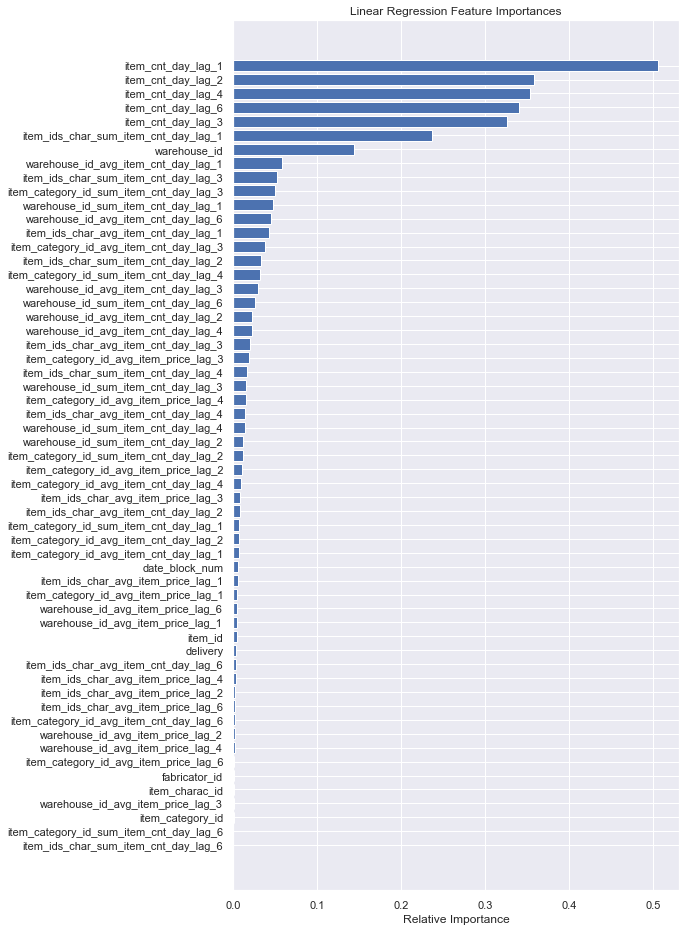

In [307]:
# Feature Importance
importances = abs(lm.coef_)
indices = np.argsort(importances)
title = 'Linear Regression Feature Importances'
hyper.plot_feature_importances(importances, indices, features, title, (8,16))

In [308]:
# Удалим нормированнные датасеты
del train_x_norm
del val_x_norm
del test_norm
gc.collect()

8919

### 2.2 XGBoost

In [309]:
# Обучение модели
gc.collect()
ts = time.time()
xgb_train = xgb.DMatrix(train_x.values, train_y.values)

param = {'max_depth': 9,             # Maximum depth of a tree
         'subsample': 1,             # Subsample ratio of the training instances
         'min_child_weight': 0.5,    # Minimum sum of instance weight (hessian) needed in a child
         'eta': 0.3,                 # Step size shrinkage used in update to prevents overfitting
         'lambda': 5,                # L2 regularization term on weights
         'num_round': 1000,          # The number of rounds for boosting
         'seed': 1,                  # Random number seed
         'verbosity': 2,             # Verbosity of printing messages
         'eval_metric': 'rmse'}      # Mean absolute error or root mean squared error

model_xgb = xgb.train(param, xgb_train)
print('Время обучения: %s мин.' %((time.time() - ts) // 60))

[10:06:31] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=9
[10:06:34] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=9
[10:06:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=9
[10:06:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=9
[10:06:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=9
[10:06:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=9
[10:06:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 pruned nodes, max_depth=9
[10:06:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=9
[10:06:51] INFO: src/tree/updater_prune.cc:74: t

In [179]:
# Качество работы модели и тестовый прогноз 0.25
train_pred_xgb, val_pred_xgb, test_pred_xgb = hyper.post_processing(model_xgb, 'xgboost', xgb.DMatrix(train_x.values), \
                                                                    xgb.DMatrix(val_x.values), xgb.DMatrix(test.values), \
                                                                    train_y, val_y, test, metric = 'rmse')

Train RMSE: 1.337323
Validation RMSE: 1.437843


In [310]:
# Качество работы модели и тестовый прогноз 0.3
train_pred_xgb, val_pred_xgb, test_pred_xgb = hyper.post_processing(model_xgb, 'xgboost', xgb.DMatrix(train_x.values), \
                                                                    xgb.DMatrix(val_x.values), xgb.DMatrix(test.values), \
                                                                    train_y, val_y, test, metric = 'rmse')

Train RMSE: 1.275346
Validation RMSE: 1.323700


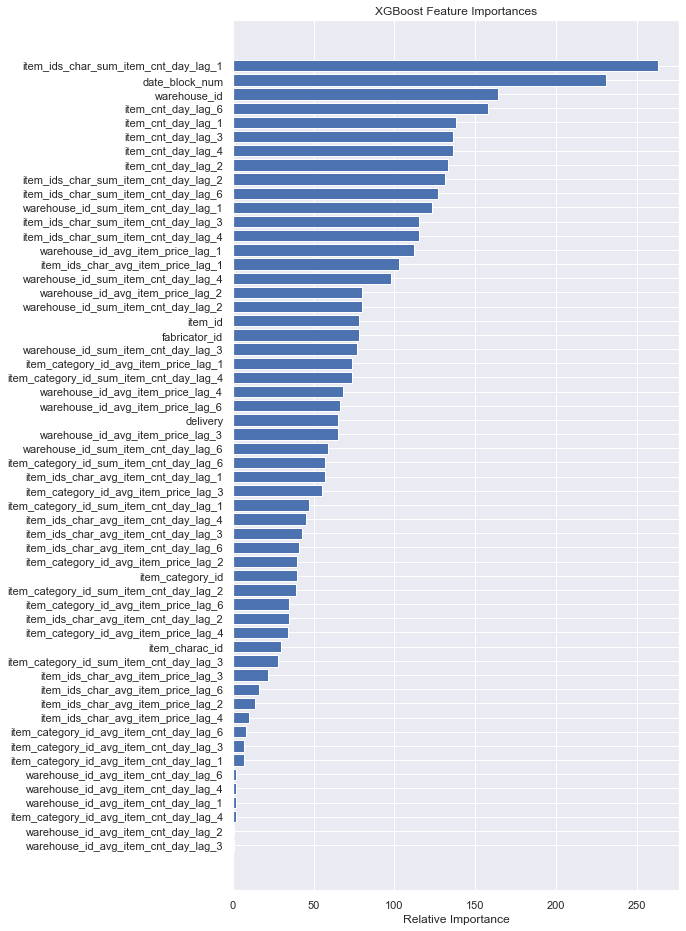

In [311]:
# Feature Importance
import operator
importance = sorted(model_xgb.get_score().items(), key = operator.itemgetter(1))
importance_v = np.asarray([x[1] for x in importance], dtype = np.int16)
indices = np.asarray([int(x[0].replace('f','')) for x in importance], dtype = np.int8)
title = 'XGBoost Feature Importances'
plt.figure(figsize = (8,16))
plt.title(title)
plt.barh(range(len(indices)), importance_v, color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show() 

### 2.3 Random Forest

In [312]:
# Обучение модели
gc.collect()
ts = time.time()

rand_forest = RandomForestRegressor(
    bootstrap = True,
    max_depth = 30,
    max_features = 3,
    min_samples_leaf = 5,
    min_samples_split = 12,
    n_estimators = 250,
    random_state = 42,
    verbose = 1,
    n_jobs = -1
)

rand_forest.fit(train_x.values, train_y.values)
print('Время обучения: %s мин.' %((time.time() - ts) / 60))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min


Время обучения: 4.472440195083618 мин.


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.5min finished


In [313]:
# Качество работы модели и тестовое предсказание
train_pred_rf, val_pred_rf, test_pred_rf = hyper.post_processing(rand_forest, 'rf', train_x, val_x, 
                                                                 test, train_y, val_y, test, metric = 'rmse')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   23.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.6s finished


Train RMSE: 1.152189
Validation RMSE: 1.294251


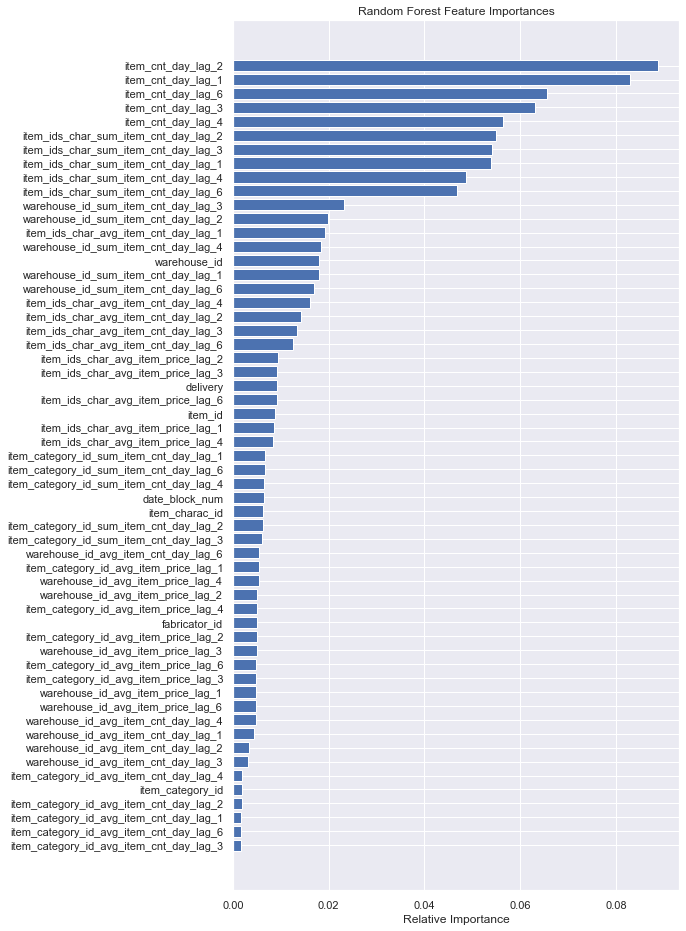

In [192]:
# Feature Importance
importances = rand_forest.feature_importances_
indices = np.argsort(importances)
title = 'Random Forest Feature Importances'
hyper.plot_feature_importances(importances, indices, features, title, (8,16))

### 2.4 Ансамбль моделей ML

In [193]:
# Подготовка данных
train_stack = pd.DataFrame({'lm': train_pred_reg, 'xgboost': train_pred_xgb, 'rf': train_pred_rf})
val_stack = pd.DataFrame({'lm': val_pred_reg, 'xgboost': val_pred_xgb, 'rf': val_pred_rf})
test_stack = pd.DataFrame({'lm': test_pred_reg, 'xgboost': test_pred_xgb, 'rf': test_pred_rf})

In [194]:
# Нормировка данных
scaler = preprocessing.StandardScaler()
scaler.fit(train_stack.values)
train_stack = scaler.transform(train_stack.values)
val_stack = scaler.transform(val_stack.values)
test_stack = scaler.transform(test_stack.values)

In [195]:
gc.collect()
ts = time.time()

# Обучение модели
stack_lm = linear_model.Ridge()
stack_lm.fit(train_stack, train_y)
print('Время обучения: %s мин.' %((time.time() - ts) / 60))

Время обучения: 0.0013630032539367677 мин.


In [196]:
# Качество работы модели и тестовое предсказание
hyper.post_processing(stack_lm, 'stack', train_stack, val_stack, test_stack, train_y, val_y, test, metric = 'rmse')

Train RMSE: 1.099113
Validation RMSE: 1.574290


(array([5.00845435e+00, 3.86133288e+00, 2.48770785e+01, ...,
        2.35408397e-03, 1.22603855e-02, 1.32747296e-01]),
 array([0.56210347, 0.64847902, 0.41385178, ..., 0.27465658, 0.34534502,
        0.32525195]),
 array([9.06724859, 7.23391115, 2.36057525, ..., 0.30922003, 0.42229504,
        0.33296083]))

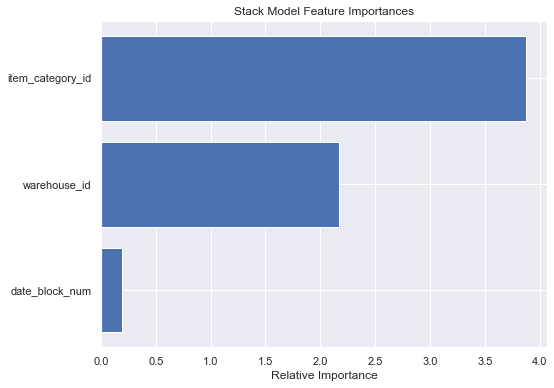

In [197]:
# Feature Importance
importances = abs(stack_lm.coef_)
indices = np.argsort(importances)
title = 'Stack Model Feature Importances'
hyper.plot_feature_importances(importances, indices, features, title, (8,6))

In [198]:
# Список уникальных складов
test.warehouse_id.unique()

array([ 45,   7,  15, 157, 123,  60, 148], dtype=int16)

# 3. Анализ полученных моделей

In [199]:
# Директория с прогнозами моделей
print(os.listdir('../notebooks'))

['.ipynb_checkpoints', 'Cut_to_train_and_test.ipynb', 'delivery_time.csv', 'Experiments.ipynb', 'Hypermrket_forcasting_sales.ipynb', 'orders_test.csv', 'output1.xlsx', 'pop38_chel_main_stats.csv', 'rf_model.pickle', 'rf_submission.csv', 'ridge_model.pickle', 'ridge_submission.csv', 'stack_model.pickle', 'stack_submission.csv', 'statistics.json', 'statistics.xlsx', 'Statistics_time_delivery_service.ipynb', 'test.pkl', 'Time_delivery_statistic.ipynb', 'train.pkl', 'val.pkl', 'with_category', 'xgboost_model.pickle', 'xgboost_submission.csv', 'yana_chel_main_stats.csv']


In [200]:
# Загружаем датафрейм реальных заказов и предсказаний моделей
real_orders = pd.read_csv('../notebooks/orders_test.csv', sep = ',')
xgb_orders = pd.read_csv('../notebooks/xgboost_submission.csv', index_col = 0, sep = ',')
rf_orders = pd.read_csv('../notebooks/rf_submission.csv', index_col = 0, sep = ',')
reg_orders = pd.read_csv('../notebooks/ridge_submission.csv', index_col = 0, sep = ',')
stack_orders = pd.read_csv('../notebooks/stack_submission.csv', index_col = 0, sep = ',')

In [201]:
# Строит графики распределений
def plot_result(df, distr, f = 'item_cnt_day'):
    plt.figure(figsize=(20, 7))
    plt.title('Распределение ' + distr + ' за август 2020 г')
    plt.xlabel('Товары + характеристики по складам')
    plt.ylabel('Число заказанных товаров за месяц')    
    df[f].plot()

In [202]:
real_orders

,warehouse_id,item_ids_char,date_block_num,item_cnt_day,item_price,item_category_id,fabricator_id,delivery
0,45,"(42712, 2)",143,5.00,1449.00,0.00,22.00,29.00
1,45,"(42716, 2)",143,5.00,983.00,0.00,22.00,29.00
2,45,"(42749, 2)",143,1.00,1419.00,0.00,22.00,29.00
3,45,"(42750, 1)",143,1.00,1875.00,0.00,22.00,29.00
4,45,"(42751, 1)",143,0.00,0.00,0.00,22.00,29.00
...,...,...,...,...,...,...,...,...
59600,148,"(60459, 9)",143,0.00,0.00,76.00,154.00,35.89
59601,148,"(65233, 1)",143,0.00,0.00,66.00,167.00,35.89
59602,148,"(69962, 1)",143,0.00,0.00,22.00,207.00,35.89
59603,148,"(72428, 2)",143,0.00,0.00,66.00,196.00,35.89


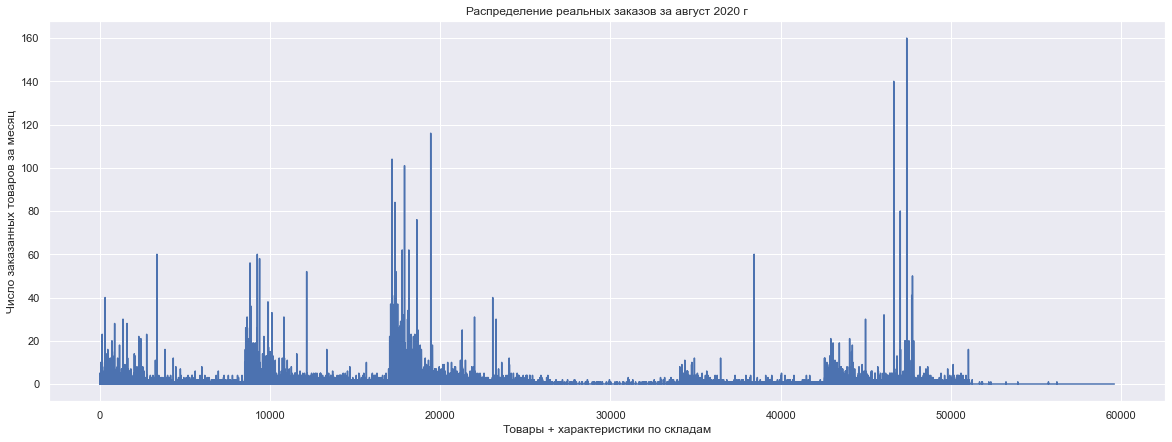

In [203]:
# Распределение реальных заказов
# за август 2020 г.
plot_result(real_orders, 'реальных заказов')

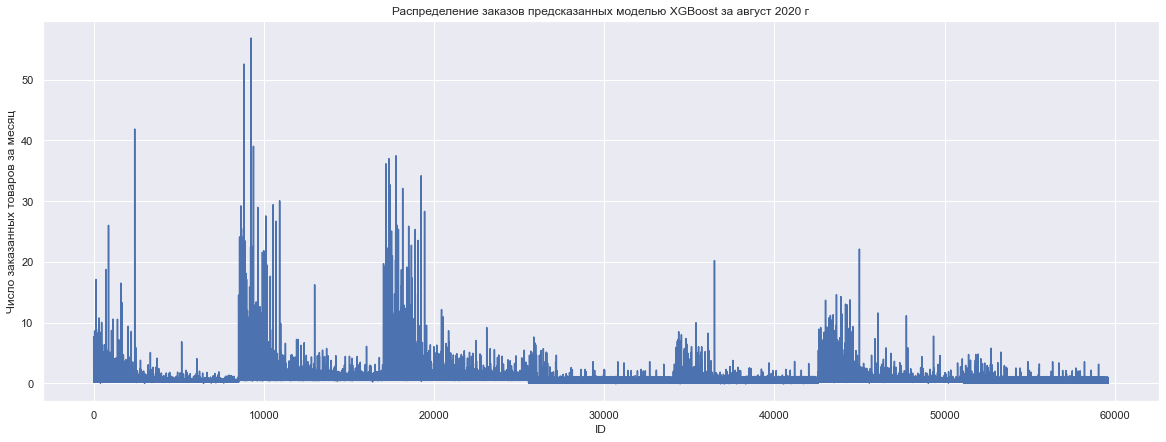

In [204]:
# Распределение заказов предсказанных 
# моделью XGBoost за август 2020 г.
plot_result(xgb_orders, 'заказов предсказанных моделью XGBoost', 'item_cnt_month')

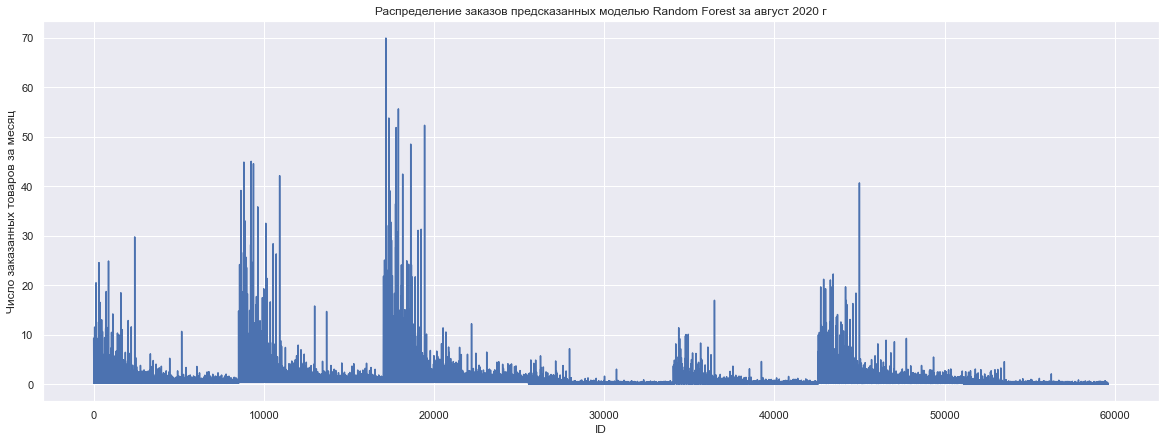

In [205]:
# Распределение заказов предсказанных 
# моделью Random Forest за август 2020 г.
plot_result(rf_orders, 'заказов предсказанных моделью Random Forest', 'item_cnt_month')

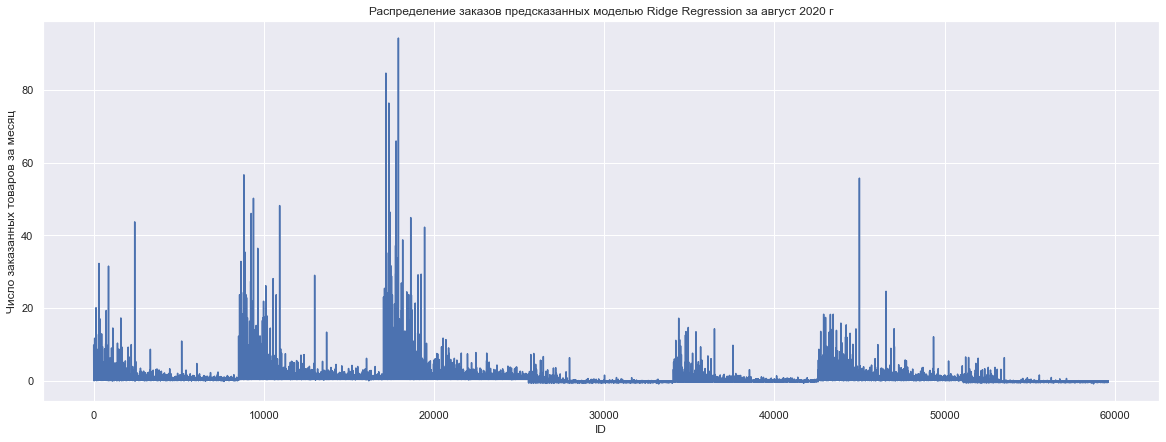

In [206]:
# Распределение заказов предсказанных 
# моделью Ridge Regression за август 2020 г.
plot_result(reg_orders, 'заказов предсказанных моделью Ridge Regression', 'item_cnt_month')

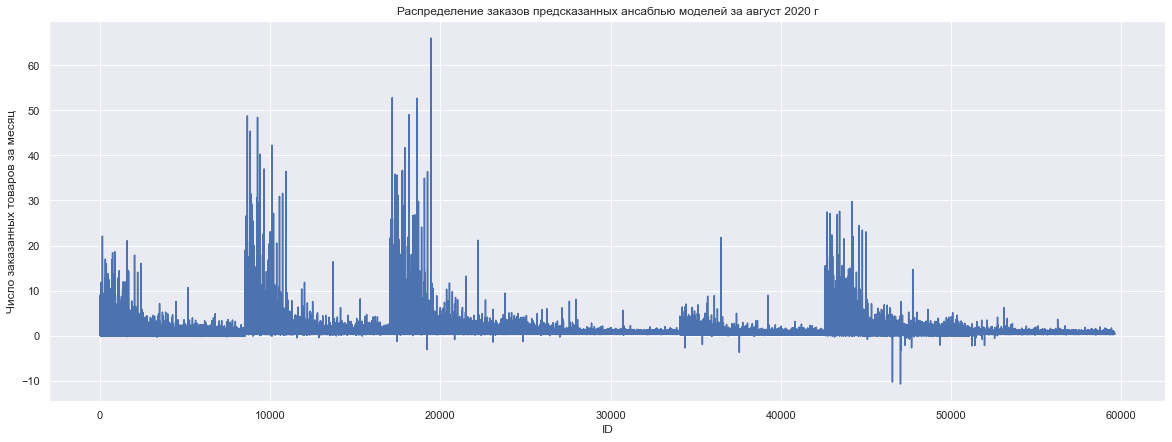

In [207]:
# Распределение заказов предсказанных 
# ансаблью моделей за август 2020 г.
plot_result(stack_orders, 'заказов предсказанных ансаблью моделей', 'item_cnt_month')

# To be continued....